In this tutorial, we show how to use RipsNet to learn the topology of very simple synthetic data sets comprised of (noisy) circles. Let's first define the seed (for reproducibility), the number of point clouds that we will use for training RipsNet, the number of point clouds we will use to test it, the cardinality of the point clouds and finally the amount of corrupted points (when noise is added).

In [1]:
N_sets_train = 900  # Number of train point clouds
N_sets_test  = 200  # Number of test  point clouds
N_points     = 600  # Point cloud cardinality
N_noise      = 200  # Number of corrupted points

### Imports


In [2]:
!pip install gudhi tqdm matplotlib scikit-learn scipy torch xgboost

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import gudhi as gd
from gudhi.representations import DiagramSelector, Landscape, PersistenceImage
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adamax
from xgboost import XGBClassifier

###utils


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adamax

class DenseRagged(nn.Module):
    def __init__(self, in_features=None, out_features=30, activation='relu', use_bias=True):
        super(DenseRagged, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        self.activation = activation

        self.weight = None
        self.bias = None

    def forward(self, inputs):
        outputs = []
        for x in inputs:
            if self.weight is None:
                in_features = x.shape[-1]
                self.weight = nn.Parameter(torch.randn(in_features, self.out_features) * 0.01)
                if self.use_bias:
                    self.bias = nn.Parameter(torch.zeros(self.out_features))
            y = torch.matmul(x, self.weight)
            if self.use_bias:
                y = y + self.bias
            if self.activation == 'relu':
                y = F.relu(y)
            elif self.activation == 'sigmoid':
                y = torch.sigmoid(y)
            elif self.activation == 'tanh':
                y = torch.tanh(y)
            outputs.append(y)
        return outputs


class PermopRagged(nn.Module):
    def forward(self, inputs):
        return torch.stack([torch.sum(x, dim=0) for x in inputs])


class RaggedPersistenceModel(nn.Module):
    def __init__(self, output_dim):
        super(RaggedPersistenceModel, self).__init__()
        self.ragged_layers = nn.ModuleList([
            DenseRagged(out_features=30, activation='relu'),
            DenseRagged(out_features=20, activation='relu'),
            DenseRagged(out_features=10, activation='relu')
        ])
        self.perm = PermopRagged()

        self.fc = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, output_dim),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        x = inputs
        for layer in self.ragged_layers:
            x = layer(x)
        x = self.perm(x)
        x = self.fc(x)
        return x

import numpy as np
from tqdm import tqdm
import gudhi as gd


####################################
###  Creation of point clouds    ###
####################################

def create_circle(N_points, r, x_0, y_0):
    X = []
    for i in range(N_points):
        theta = np.random.uniform() * 2 * np.pi
        X.append([(r * np.cos(theta)) + x_0, (r * np.sin(theta) + y_0)])
    return np.array(X)


def create_1_circle_clean(N_points):
    r = 2
    x_0, y_0 = 10 * np.random.rand() - 5, 10 * np.random.rand() - 5
    return create_circle(N_points, r, x_0, y_0)


def create_2_circle_clean(N_points):
    r1 = 5
    r2 = 3
    x_0, y_0 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    x_1, y_1 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    while np.sqrt((x_0 - x_1) ** 2 + (y_0 - y_1) ** 2) <= r1 + r2:
        x_1, y_1 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    circle1 = create_circle(N_points // 2, r1, x_0, y_0)
    circle2 = create_circle(N_points - N_points // 2, r2, x_1, y_1)
    X = [0] * N_points
    X[:N_points // 2] = circle1
    X[N_points // 2:] = circle2
    np.random.shuffle(X)
    return np.array(X)


def create_3_circle_clean(N_points):
    r0 = 5
    r1 = 3
    r2 = 2
    x_0, y_0 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    x_1, y_1 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    while np.sqrt((x_0 - x_1) ** 2 + (y_0 - y_1) ** 2) <= r0 + r1:
        x_1, y_1 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15

    x_2, y_2 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    while(np.sqrt((x_0 - x_2)**2 + (y_0 - y_2)**2) <= r0 + r2) or (np.sqrt((x_1 - x_2)**2 + (y_1 - y_2)**2) <= r1 + r2):
        x_2, y_2 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15

    circle0 = create_circle(N_points // 3, r0, x_0, y_0)
    circle1 = create_circle(N_points // 3, r1, x_1, y_1)
    circle2 = create_circle(N_points // 3, r2, x_2, y_2)

    # Handler in case N_points mod 3 != 0.
    true_N_points = 3 * (N_points // 3)

    X = [[0,0]] * true_N_points
    X[:true_N_points // 3] = circle0
    X[true_N_points // 3:2 * true_N_points // 3] = circle1
    X[2 * true_N_points // 3:] = circle2
    np.random.shuffle(X)
    return np.array(X)


def create_1_circle_noisy(N_points, N_noise):
    r = 2
    x_0, y_0 = 10 * np.random.rand() - 5, 10 * np.random.rand() - 5
    X = create_circle(N_points, r, x_0, y_0)
    noise = []
    for i in range(N_noise):
        noise.append([np.random.uniform(x_0 - r, x_0 + r),
                      np.random.uniform(y_0 - r, y_0 + r)])
    X = np.array(X)
    X[np.random.choice(np.arange(len(X)), size=N_noise, replace=False, p=None)] = np.array(noise)
    return X


def create_2_circle_noisy(N_points, N_noise):
    r1 = 5
    r2 = 3
    x_0, y_0 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    x_1, y_1 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    while(np.sqrt((x_0 - x_1)**2 + (y_0 - y_1)**2) <= r1 + r2):
        x_1, y_1 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    circle1 = create_circle(N_points // 2, r1, x_0, y_0)
    circle2 = create_circle(N_points - N_points // 2, r2, x_1, y_1)
    X = [0] * N_points
    X[:N_points // 2] = circle1
    X[N_points // 2:] = circle2
    np.random.shuffle(X)
    noise = []
    for i in range(N_noise):
        noise.append([np.random.uniform(min(x_0 - r1, x_1 - r2), max(x_0 + r1, x_1 + r2)),
                      np.random.uniform(min(y_0 - r1, y_1 - r2), max(y_0 + r1, y_1 + r2))])
    X = np.array(X)
    X[np.random.choice(np.arange(len(X)), size=N_noise, replace=False, p=None)] = np.array(noise)
    return X


def create_3_circle_noisy(N_points, N_noise):
    r0 = 5
    r1 = 3
    r2 = 2
    x_0, y_0 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    x_1, y_1 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    while np.sqrt((x_0 - x_1) ** 2 + (y_0 - y_1) ** 2) <= r0 + r1:
        x_1, y_1 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    x_2, y_2 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    while(np.sqrt((x_0 - x_2)**2 + (y_0 - y_2)**2) <= r0 + r2) or (np.sqrt((x_1 - x_2)**2 + (y_1 - y_2)**2) <= r1 + r2):
        x_2, y_2 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    circle0 = create_circle(N_points // 3, r0, x_0, y_0)
    circle1 = create_circle(N_points // 3, r1, x_1, y_1)
    circle2 = create_circle(N_points // 3, r2, x_2, y_2)

    true_N_points = 3 * (N_points // 3)
    X = [[0,0]] * true_N_points
    X[:true_N_points // 3] = circle0
    X[true_N_points // 3:2 * true_N_points // 3] = circle1
    X[2 * true_N_points // 3:] = circle2

    np.random.shuffle(X)
    noise = []
    for i in range(N_noise):
        noise.append([np.random.uniform(np.min([x_0 - r0, x_1 - r1, x_2 - r2]), np.max([x_0 + r0, x_1 + r1, x_2 + r2])),
                      np.random.uniform(np.min([y_0 - r0, y_1 - r1, y_2 - r2]), np.max([y_0 + r0, y_1 + r1, y_2 + r2]))])
    X = np.array(X)
    X[np.random.choice(np.arange(len(X)), size=N_noise, replace=False, p=None)] = np.array(noise)
    return X

def augment_isometries(pc, n, rng, trans_frac=0.08):
    bbox = pc.max(axis=0) - pc.min(axis=0)
    t_max = trans_frac * np.linalg.norm(bbox)  # translation scale relative to cloud size
    augmented = []
    for _ in range(n):
        theta = rng.uniform(0, 2 * np.pi)
        R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        t = rng.uniform(-t_max, t_max, size=2)
        augmented.append((pc @ R.T) + t)
    return augmented

def data_augmentation_by_isometries(data_train, label_train, n_augment_per_sample, seed=42):
    rng = np.random.default_rng(seed)
    aug_data, aug_labels = [], []
    for pc, lbl in zip(data_train, label_train):
        aug_data.append(pc)
        aug_labels.append(lbl)
        for pc_aug in augment_isometries(pc, n_augment_per_sample, rng):
            aug_data.append(pc_aug)
            aug_labels.append(lbl)
    return aug_data, aug_labels

def create_multiple_circles(N_sets_train, N_points, noisy=False, N_noise=0, n_augment_per_sample = 0):

    data_train, PD_train = [[] for _ in range(N_sets_train)], []
    label_train = np.zeros((N_sets_train,))

    if not noisy:
        for i in tqdm(range(N_sets_train // 3)):
            data_train[i] = create_1_circle_clean(N_points)
            label_train[i] = 1
        for i in tqdm(range(N_sets_train // 3, 2 * N_sets_train // 3)):
            data_train[i] = create_2_circle_clean(N_points)
            label_train[i] = 2
        for i in tqdm(range(2 * N_sets_train // 3, N_sets_train)):
            data_train[i] = create_3_circle_clean(N_points)
            label_train[i] = 3
    else:
        for i in tqdm(range(N_sets_train // 3)):
            data_train[i] = create_1_circle_noisy(N_points, N_noise)
            label_train[i] = 1
        for i in tqdm(range(N_sets_train // 3, 2 * N_sets_train // 3)):
            data_train[i] = create_2_circle_noisy(N_points, N_noise)
            label_train[i] = 2
        for i in tqdm(range(2 * N_sets_train // 3, N_sets_train)):
            data_train[i] = create_3_circle_noisy(N_points, N_noise)
            label_train[i] = 3

    shuffler = np.random.permutation(len(data_train))
    label_train = label_train[shuffler]
    data_train = [data_train[p] for p in shuffler]
    if (n_augment_per_sample > 0):
        data_train,label_train = data_augmentation_by_isometries(data_train, label_train, n_augment_per_sample, seed=42)
    return data_train, label_train


############################################
### Computation of persistence diagrams  ###
############################################


def compute_PD(dataset, i):
    u = np.array(dataset[i])
    rcX = gd.AlphaComplex(points=u).create_simplex_tree()
    rcX.persistence()
    dgm = rcX.persistence_intervals_in_dimension(1)
    return dgm

### Definition of our Train/Test sets
Next we use helper functions to compute these point clouds.

In [5]:
data_train,      label_train       = create_multiple_circles(N_sets_train, N_points, noisy=1, N_noise=N_noise, n_augment_per_sample= 0)
clean_data_test, clean_label_test  = create_multiple_circles(N_sets_test,  N_points, noisy=0, N_noise=N_noise,n_augment_per_sample= 0)
noisy_data_test, noisy_label_test  = create_multiple_circles(N_sets_test,  N_points, noisy=1, N_noise=N_noise)

100%|██████████| 67/67 [00:01<00:00, 36.13it/s]


Let's check some of these point clouds!

#### Plotting Point Clouds

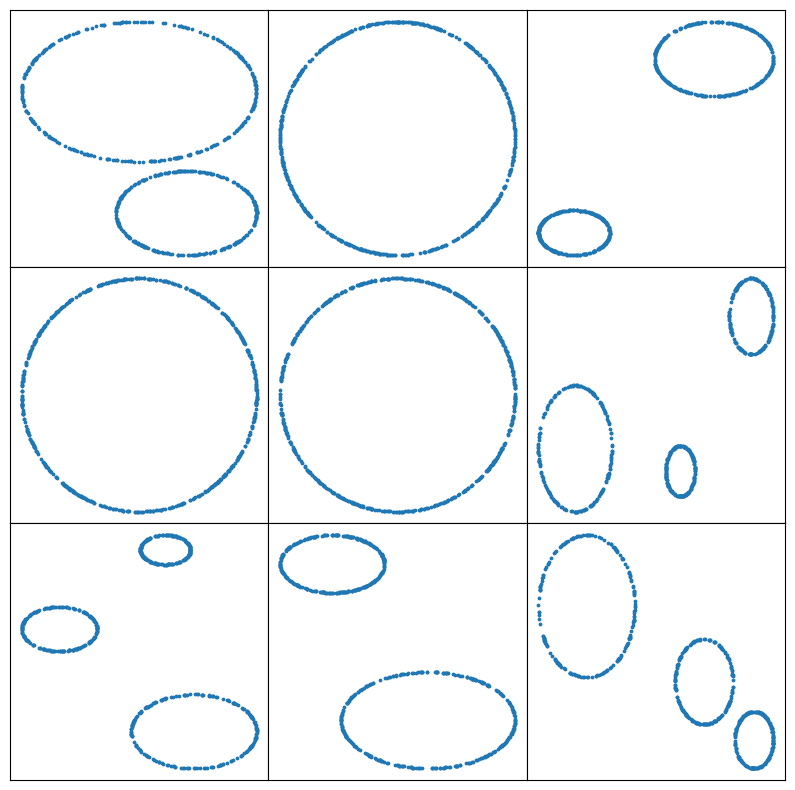

In [6]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(clean_data_test[3*i+j][:,0], clean_data_test[3*i+j][:,1], s=3)
        plt.xticks([])
        plt.yticks([])
plt.savefig('clean_gudhi_pc.png', bbox_inches='tight')

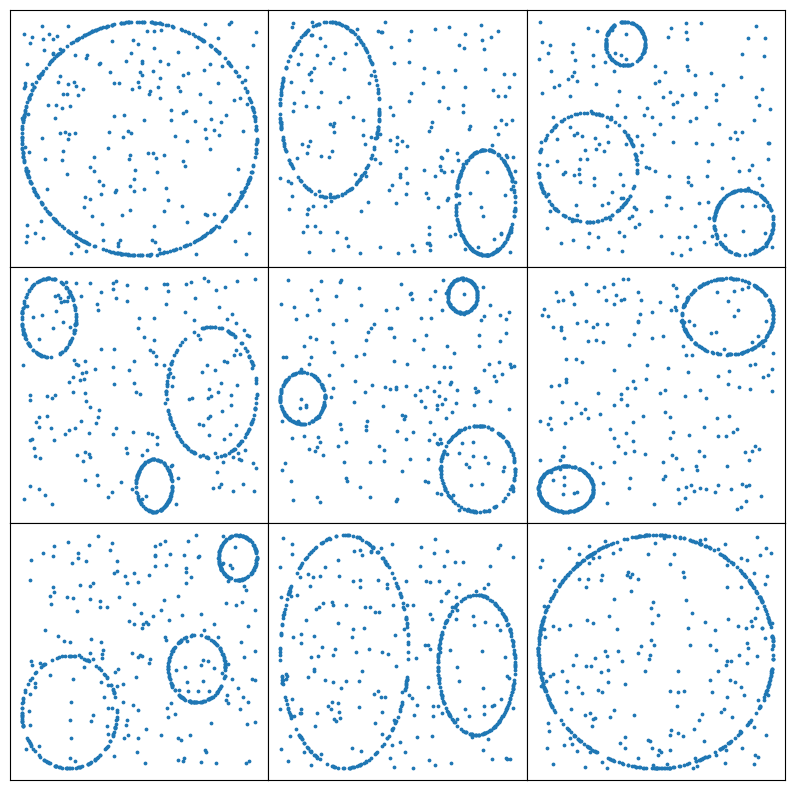

In [7]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(noisy_data_test[3*i+j][:,0], noisy_data_test[3*i+j][:,1], s=3)
        plt.xticks([])
        plt.yticks([])
plt.savefig('noisy_gudhi_pc.png', bbox_inches='tight')

#### Cleaning Labels
As one can see, they contain 1 to 3 circular shapes. We will use these circle numbers later for checking the accuracy of the topology computed by RipsNet. For now, let's save them as proper labels.

In [8]:
le = LabelEncoder().fit(label_train)
label_classif_train = le.transform(label_train)
clean_label_classif_test  = le.transform(clean_label_test)
noisy_label_classif_test  = le.transform(noisy_label_test)

#### Distance Matrix


In [9]:
def distance_matrix(point_cloud):
    """
    Compute pairwise Euclidean distance matrix for a point cloud.
    Accepts numpy array, list-of-lists, or torch.Tensor of shape (N, d).
    Returns a numpy array of shape (N, N).
    """
    # rely on existing imports: np, torch
    if isinstance(point_cloud, __import__("torch").Tensor):
        point_cloud = point_cloud.cpu().numpy()
    pc = np.asarray(point_cloud, dtype=float)
    if pc.ndim == 1:
        pc = pc.reshape(-1, 1)
    diff = pc[:, None, :] - pc[None, :, :]
    return np.sqrt((diff ** 2).sum(axis=-1))

### Topology of point clouds

In order to train RipsNet, we need the correct topology on the train data. So let's compute it with [Gudhi](https://gudhi.inria.fr/python/latest/). The topology of point clouds can be inferred from several filtrations, so we will use a fast and sparse one (in 2D), namely the [Alpha filtration](https://gudhi.inria.fr/python/latest/alpha_complex_user.html). First, we need to get a sense of the maximal filtration value to use, which we will approximate with the largest pairwise distance of the first 30 point clouds.

In [10]:
ds = [pairwise_distances(X).flatten() for X in data_train[:30]]
maxd = np.max(np.concatenate(ds))

#### Persistence diagrams
Now, we can compute the persistence diagrams (in homology dimension 1) of the train, clean test and noisy test point clouds!

In [11]:
PD_train = []
for X in tqdm(data_train):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    PD_train.append(dg)

100%|██████████| 900/900 [00:19<00:00, 45.45it/s] 


In [12]:
clean_PD_test = []
for X in tqdm(clean_data_test):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    clean_PD_test.append(dg)

100%|██████████| 200/200 [00:03<00:00, 59.77it/s]


In [13]:
noisy_PD_test = []
for X in tqdm(noisy_data_test):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    noisy_PD_test.append(dg)

100%|██████████| 200/200 [00:01<00:00, 104.20it/s]


#### Persistence Image & Persistence Landscape
RipsNet actually works on vectorizations of persistence diagrams (PDs), so we will try two: the [persistence image](https://jmlr.org/papers/volume18/16-337/16-337.pdf), and the [persistence landscape](https://jmlr.csail.mit.edu/papers/volume16/bubenik15a/bubenik15a.pdf). First, let's filter out any PD point with infinite coordinates.

In [14]:
pds_train      = DiagramSelector(use=True).fit_transform(PD_train)
clean_pds_test = DiagramSelector(use=True).fit_transform(clean_PD_test)
noisy_pds_test = DiagramSelector(use=True).fit_transform(noisy_PD_test)

Fortunately, Gudhi also has code for computing vectorizations!! However, before launching the computations, we have to estimate a few parameters: the image bandwidth (taken as the 20% quantile of the positive birth-persistence-transformed-PD pairwise distances),
and the image and landscape limits (taken as the min and max of birth-persistence-transformed-PD point coordinates).

In [15]:
vpdtr = np.vstack(pds_train)
pers = vpdtr[:,1]-vpdtr[:,0]
bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
sigma = np.quantile(ppers, .2)
im_bnds = [np.quantile(vpdtr[:,0],0.), np.quantile(vpdtr[:,0],1.), np.quantile(pers,0.), np.quantile(pers,1.)]
sp_bnds = [np.quantile(vpdtr[:,0],0.), np.quantile(vpdtr[:,1],1.)]

We can now compute and normalize the vectorizations (this can help RipsNet training)!

In [16]:
if 'im_bnds' not in locals() or im_bnds is None:
    all_points = np.concatenate(pds_train, axis=0)
    x_min, x_max = np.min(all_points[:, 0]), np.max(all_points[:, 0])
    y_min, y_max = np.min(all_points[:, 1]), np.max(all_points[:, 1])
    im_bnds = [x_min, x_max, y_min, y_max]

PI_params = {
    'bandwidth': sigma,
    'weight': lambda x: 10 * np.tanh(x[1]),
    'resolution': [50, 50],
    'im_range': im_bnds
}

PI = PersistenceImage(**PI_params)
PI.fit(pds_train)

PI_train = PI.transform(pds_train)
clean_PI_test = PI.transform(clean_pds_test)
noisy_PI_test = PI.transform(noisy_pds_test)

MPI = np.max(PI_train)
if MPI == 0 or np.isnan(MPI):
    raise ValueError("MPI (max value) is zero or NaN; check persistence diagrams.")
else:
    PI_train /= MPI
    clean_PI_test /= MPI
    noisy_PI_test /= MPI

PI_train = torch.tensor(PI_train, dtype=torch.float32)
clean_PI_test = torch.tensor(clean_PI_test, dtype=torch.float32)
noisy_PI_test = torch.tensor(noisy_PI_test, dtype=torch.float32)

print(f"PI_train shape: {PI_train.shape}")
print(f"clean_PI_test shape: {clean_PI_test.shape}")
print(f"noisy_PI_test shape: {noisy_PI_test.shape}")
print(f"Max pixel intensity (MPI): {MPI:.5f}")


PI_train shape: torch.Size([900, 2500])
clean_PI_test shape: torch.Size([200, 2500])
noisy_PI_test shape: torch.Size([200, 2500])
Max pixel intensity (MPI): 406.89401


In [17]:

if 'sp_bnds' not in locals() or sp_bnds is None:
    all_points = np.concatenate(pds_train, axis=0)
    x_min, x_max = np.min(all_points[:, 0]), np.max(all_points[:, 1])
    sp_bnds = [x_min, x_max]


PL_params = {
    'num_landscapes': 5,
    'resolution': 300,
    'sample_range': sp_bnds
}

PL = Landscape(**PL_params)
PL.fit(pds_train)

PL_train = PL.transform(pds_train)
clean_PL_test = PL.transform(clean_pds_test)
noisy_PL_test = PL.transform(noisy_pds_test)

MPL = np.max(PL_train)
if MPL == 0 or np.isnan(MPL):
    raise ValueError("MPL (max landscape value) is zero or NaN; check your persistence diagrams.")
else:
    PL_train /= MPL
    clean_PL_test /= MPL
    noisy_PL_test /= MPL

PL_train = torch.tensor(PL_train, dtype=torch.float32)
clean_PL_test = torch.tensor(clean_PL_test, dtype=torch.float32)
noisy_PL_test = torch.tensor(noisy_PL_test, dtype=torch.float32)

print(f"PL_train shape: {PL_train.shape}")
print(f"clean_PL_test shape: {clean_PL_test.shape}")
print(f"noisy_PL_test shape: {noisy_PL_test.shape}")
print(f"Max landscape value (MPL): {MPL:.5f}")


PL_train shape: torch.Size([900, 1500])
clean_PL_test shape: torch.Size([200, 1500])
noisy_PL_test shape: torch.Size([200, 1500])
Max landscape value (MPL): 10.15628


### Time to Train !
It is finally time to train RipsNet! We will do it with Pytorch, and custom DeepSet operations.

## Model Summary: RipsNet (RaggedPersistenceModel)

**Structure:**
RipsNet, implemented as `RaggedPersistenceModel`, is a neural network designed to process varying-sized inputs (like point clouds) using a DeepSet-like architecture. It consists of:
1.  **Ragged Layers (`DenseRagged`):** These are essentially fully-connected layers applied independently to each point in the input point cloud. They learn per-point features. The `DenseRagged` class handles the variable size of point clouds by applying the same weights to each point and operating on lists of tensors.
2.  **Permutation-Invariant Pooling (`PermopRagged`):** After the ragged layers, a permutation-invariant operation (in this case, summation across all point features) is applied to aggregate the per-point features into a fixed-size global descriptor for the entire point cloud.
3.  **Fully Connected Layers (`fc`):** A series of standard fully-connected layers process the global descriptor to produce the final output, which is a vectorized topological descriptor (either a Persistence Image or a Persistence Landscape).

**Motivation:**
RipsNet was proposed to overcome the computational bottleneck of traditional Topological Data Analysis (TDA) methods, which are often slow when applied to large datasets. The key idea is to *learn* a mapping from raw point cloud data directly to stable topological descriptors (like Persistence Images or Landscapes), bypassing the explicit computation of persistence diagrams. This allows for faster processing of new data points and integrates topological feature extraction into an end-to-end learning framework. Its DeepSet architecture inherently handles the unordered nature of point clouds.

## Model Summary: DistanceMatrixRaggedModel

**Structure:**
The `DistanceMatrixRaggedModel` is an adaptation designed to predict topological descriptors directly from pairwise distance matrices of point clouds. It incorporates optional Graph Neural Network (GNN) layers to enrich feature learning:
1.  **Per-Row MLP (`_phi_mlp`):** Each row of the input distance matrix is treated as a feature vector for a point. A multi-layer perceptron (MLP) transforms these per-row feature vectors into a higher-dimensional embedding for each point.
2.  **GNN-like Aggregation (Optional):** If `gnn_enabled` is true, the model constructs an adjacency matrix from the distance matrix (representing connections between points) and applies graph convolutional layers. These layers facilitate message passing and aggregation of features between neighboring points, allowing the model to learn context-aware features.
3.  **Global Pooling:** After the per-point feature extraction (and optional GNN layers), a global pooling operation (summation) aggregates the point-wise features into a single, fixed-size vector representing the entire point cloud.
4.  **Fully Connected Layers (`rho`):** A final set of fully-connected layers processes this global descriptor to produce the target topological representation.

**Motivation:**
This model was proposed to leverage the inherent permutation invariance and isometry invariance of distance matrices. By taking the distance matrix as input, the model is inherently robust to rigid transformations (rotations and translations) of the point cloud. The optional GNN layers aim to capture local and global geometric relationships within the point cloud more effectively by explicitly modeling the graph structure derived from distances, potentially leading to richer and more robust topological feature learning, especially for noisy data.

## Model Summary: PointNet

**Structure:**
The `PointNet` model implemented here is a simplified version of the seminal PointNet architecture, designed for processing raw point clouds while respecting their unordered nature. It comprises:
1.  **Shared MLP (`phi_layers`):** An MLP is applied independently to each point's coordinates (in this case, 2D coordinates `(x, y)`). This MLP transforms each point into a higher-dimensional feature vector. The weights of this MLP are shared across all points, ensuring permutation invariance for this step.
2.  **Max-Pooling (Permutation-Invariant Aggregation):** After the shared MLP, a global max-pooling operation is applied across all per-point features. This operation selects the maximum value for each feature dimension across all points, resulting in a single, fixed-size global feature vector for the entire point cloud. Max-pooling is inherently permutation-invariant.
3.  **Global MLP (`rho_layers`):** A series of fully-connected layers (rho function) process the global feature vector obtained from max-pooling to produce the final output, which is the predicted topological descriptor (Persistence Image or Persistence Landscape).

**Motivation:**
PointNet was proposed to directly consume unordered point clouds, without the need for conversion to intermediate representations like meshes or voxel grids. Its core innovation lies in its ability to achieve permutation invariance through shared MLP weights and symmetric aggregation functions (like max-pooling). This allows the network to learn rich features from each point individually and then combine them in a way that is robust to the arbitrary ordering of points, making it suitable for tasks like shape classification, part segmentation, and, in this context, learning topological descriptors.

First, let's convert the point clouds into ragged tensors.

In [18]:
tf_data_train = [torch.tensor(pc, dtype=torch.float32) for pc in data_train]
tf_clean_data_test = [torch.tensor(pc, dtype=torch.float32) for pc in clean_data_test]
tf_noisy_data_test = [torch.tensor(pc, dtype=torch.float32) for pc in noisy_data_test]

Next, we define our RipsNet architecture for learning persistence images, a sequence of fully-connected DeepSet layers, with ReLu activations, Adamax optimizer, and early stopping.

In [19]:
output_dim = PI_train.shape[1]
model_PI = RaggedPersistenceModel(output_dim=output_dim)

optimizer = Adamax(model_PI.parameters(), lr=5e-4)
criterion = nn.MSELoss()

Time to learn!

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, optimizer, criterion, train_inputs, train_targets, val_inputs, val_targets, epochs=20, batch_size=32):
    """
    Train a ragged-input model. Returns (best_model, history, best_model_state).
    """
    model = model.to(device)
    patience = 20
    best_val_loss = float('inf')
    patience_counter = 0
    num_epochs = epochs if epochs is not None else 10000
    history = {'train_loss': [], 'val_loss': []}
    best_model_state = None

    # helper to move inputs to device
    def to_device_list(lst):
        out = []
        for x in lst:
            if isinstance(x, torch.Tensor):
                out.append(x.to(device).float())
            else:
                out.append(torch.tensor(x, dtype=torch.float32, device=device))
        return out

    train_inputs = to_device_list(train_inputs)
    val_inputs = to_device_list(val_inputs)

    if isinstance(train_targets, torch.Tensor):
        train_targets = train_targets.to(device).float()
    else:
        train_targets = torch.tensor(train_targets, dtype=torch.float32, device=device)

    if isinstance(val_targets, torch.Tensor):
        val_targets = val_targets.to(device).float()
    else:
        val_targets = torch.tensor(val_targets, dtype=torch.float32, device=device)

    for epoch in range(num_epochs):
        model.train()
        permutation = torch.randperm(len(train_inputs), device=device)
        epoch_loss = 0.0
        for i in range(0, len(train_inputs), batch_size):
            optimizer.zero_grad()
            indices = permutation[i:i + batch_size]
            batch_inputs = [train_inputs[int(idx)].to(device) for idx in indices]
            batch_targets = train_targets[indices]

            outputs = model(batch_inputs)
            if isinstance(outputs, (list, tuple)):
                outputs = outputs[0]
            if not isinstance(outputs, torch.Tensor):
                outputs = torch.tensor(outputs, dtype=batch_targets.dtype, device=device)
            else:
                outputs = outputs.to(device).type(batch_targets.dtype)

            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * len(batch_inputs)

        epoch_loss /= len(train_inputs)
        history['train_loss'].append(epoch_loss)

        model.eval()
        with torch.no_grad():
            val_outputs = model(val_inputs)
            if isinstance(val_outputs, (list, tuple)):
                val_outputs = val_outputs[0]
            val_outputs = val_outputs.to(device).type(val_targets.dtype)
            val_loss = criterion(val_outputs, val_targets).item()
            history['val_loss'].append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.6f}, Val Loss: {val_loss:.6f}')

        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            patience_counter = 0
            # save best model (on CPU to avoid holding GPU memory)
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # if we saved a best state, load it back into the model on the current device
    if best_model_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})

    return model, history, best_model_state

In [21]:
# Training RipsNet to predict Persistence Images (original training loop)
model = model_PI
criterion = nn.MSELoss()
optimizer = torch.optim.Adamax(model_PI.parameters(), lr=5e-4)
train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
train_targets = torch.tensor(PI_train, dtype=torch.float32).to(device)
val_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
val_targets = torch.tensor(clean_PI_test, dtype=torch.float32).to(device)

/tmp/ipython-input-1374235358.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
/tmp/ipython-input-1374235358.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_targets = torch.tensor(PI_train, dtype=torch.float32).to(device)
/tmp/ipython-input-1374235358.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
/tmp/ipython-input-1374235358.py:8: UserWarning:

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Redefining DenseRagged to correctly handle device placement of dynamically created parameters
class DenseRagged(nn.Module):
    def __init__(self, in_features=None, out_features=30, activation='relu', use_bias=True):
        super(DenseRagged, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        self.activation = activation

        # Parameters will be initialized on first forward pass.
        self.weight_param = None # Use distinct names for registered parameters
        self.bias_param = None

    def forward(self, inputs):
        outputs = []
        for x in inputs:
            if self.weight_param is None: # Check if parameters have been initialized
                in_features = x.shape[-1]
                # Initialize weight on the same device as input x
                self.weight_param = nn.Parameter(torch.randn(in_features, self.out_features, device=x.device) * 0.01)
                self.register_parameter('weight_param', self.weight_param) # Register the parameter
                if self.use_bias:
                    # Initialize bias on the same device as input x
                    self.bias_param = nn.Parameter(torch.zeros(self.out_features, device=x.device))
                    self.register_parameter('bias_param', self.bias_param) # Register the parameter

            y = torch.matmul(x, self.weight_param) # Use the registered parameter
            if self.use_bias:
                y = y + self.bias_param # Use the registered parameter
            if self.activation == 'relu':
                y = F.relu(y)
            elif self.activation == 'sigmoid':
                y = torch.sigmoid(y)
            elif self.activation == 'tanh':
                y = torch.tanh(y)
            outputs.append(y)
        return outputs

# Redefining PermopRagged (no changes needed, but must be in scope if RaggedPersistenceModel is redefined)
class PermopRagged(nn.Module):
    def forward(self, inputs):
        return torch.stack([torch.sum(x, dim=0) for x in inputs])

# Redefining RaggedPersistenceModel to use the corrected DenseRagged
class RaggedPersistenceModel(nn.Module):
    def __init__(self, output_dim):
        super(RaggedPersistenceModel, self).__init__()
        self.ragged_layers = nn.ModuleList([
            DenseRagged(out_features=30, activation='relu'),
            DenseRagged(out_features=20, activation='relu'),
            DenseRagged(out_features=10, activation='relu')
        ])
        self.perm = PermopRagged()

        self.fc = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, output_dim),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        x = inputs
        for layer in self.ragged_layers:
            x = layer(x)
        x = self.perm(x)
        x = self.fc(x)
        return x

# Re-instantiate model_PI with the new class definition
output_dim = PI_train.shape[1]
model_PI = RaggedPersistenceModel(output_dim=output_dim)

# Re-prepare inputs to avoid UserWarnings and ensure they are on the correct device.
# Assuming tf_data_train, PI_train, tf_clean_data_test, clean_PI_test are correctly defined
# and `device` is set up.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_inputs = [pc.to(device) for pc in tf_data_train]
train_targets = PI_train.to(device)
val_inputs = [pc.to(device) for pc in tf_clean_data_test]
val_targets = clean_PI_test.to(device)

# Redefine optimizer here to use the new model_PI parameters.
optimizer = Adamax(model_PI.parameters(), lr=5e-4)
criterion = nn.MSELoss() # Criterion remains the same

# Ensure num_epochs is defined
try:
    num_epochs
except NameError:
    num_epochs = 10000

model_PI, history_PI, best_model_state = train_model(
    model_PI, optimizer, criterion,
    train_inputs, train_targets,
    val_inputs, val_targets,
    epochs=num_epochs, batch_size=32
)

best_val_loss = min(history_PI['val_loss']) if history_PI.get('val_loss') else float('inf')
print(f"Training complete. Best val_loss = {best_val_loss:.6f}")

Epoch 1/10000, Train Loss: 0.234813, Val Loss: 0.213279
Epoch 2/10000, Train Loss: 0.174116, Val Loss: 0.118005
Epoch 3/10000, Train Loss: 0.061196, Val Loss: 0.015693
Epoch 4/10000, Train Loss: 0.006975, Val Loss: 0.002529
Epoch 5/10000, Train Loss: 0.001926, Val Loss: 0.001170
Epoch 6/10000, Train Loss: 0.001108, Val Loss: 0.000736
Epoch 7/10000, Train Loss: 0.000767, Val Loss: 0.000513
Epoch 8/10000, Train Loss: 0.000581, Val Loss: 0.000389
Epoch 9/10000, Train Loss: 0.000472, Val Loss: 0.000310
Epoch 10/10000, Train Loss: 0.000404, Val Loss: 0.000259
Epoch 11/10000, Train Loss: 0.000362, Val Loss: 0.000227
Epoch 12/10000, Train Loss: 0.000336, Val Loss: 0.000212
Epoch 13/10000, Train Loss: 0.000319, Val Loss: 0.000199
Epoch 14/10000, Train Loss: 0.000308, Val Loss: 0.000198
Epoch 15/10000, Train Loss: 0.000300, Val Loss: 0.000188
Epoch 16/10000, Train Loss: 0.000294, Val Loss: 0.000185
Epoch 17/10000, Train Loss: 0.000290, Val Loss: 0.000184
Epoch 18/10000, Train Loss: 0.000287, Va

Learning is done! The advantage of RipsNet is that we can now use it to predict persistence images directly from point clouds in the blink of an eye!Let's see how accurate the predictions of RipsNet really are, at least on the train set.

In [23]:
model_PI.eval()

with torch.no_grad():
    # ensure inputs have the same dtype as the model parameters (float32)
    train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
    clean_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
    noisy_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_noisy_data_test]

    train_PI_prediction = model_PI(train_inputs).cpu().numpy()
    clean_PI_prediction = model_PI(clean_inputs).cpu().numpy()
    noisy_PI_prediction = model_PI(noisy_inputs).cpu().numpy()

print("Predictions computed:")
print(f"train_PI_prediction shape: {train_PI_prediction.shape}")
print(f"clean_PI_prediction shape: {clean_PI_prediction.shape}")
print(f"noisy_PI_prediction shape: {noisy_PI_prediction.shape}")


/tmp/ipython-input-2216463292.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
/tmp/ipython-input-2216463292.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clean_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
/tmp/ipython-input-2216463292.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_noisy_data_test]


Predictions computed:
train_PI_prediction shape: (900, 2500)
clean_PI_prediction shape: (200, 2500)
noisy_PI_prediction shape: (200, 2500)


Pretty good actually! Let's look at the test set now.

Saved noisy_gudhi_pc.png
Saved noisy_gudhi_pi.png
Saved noisy_ripsnet_pi.png


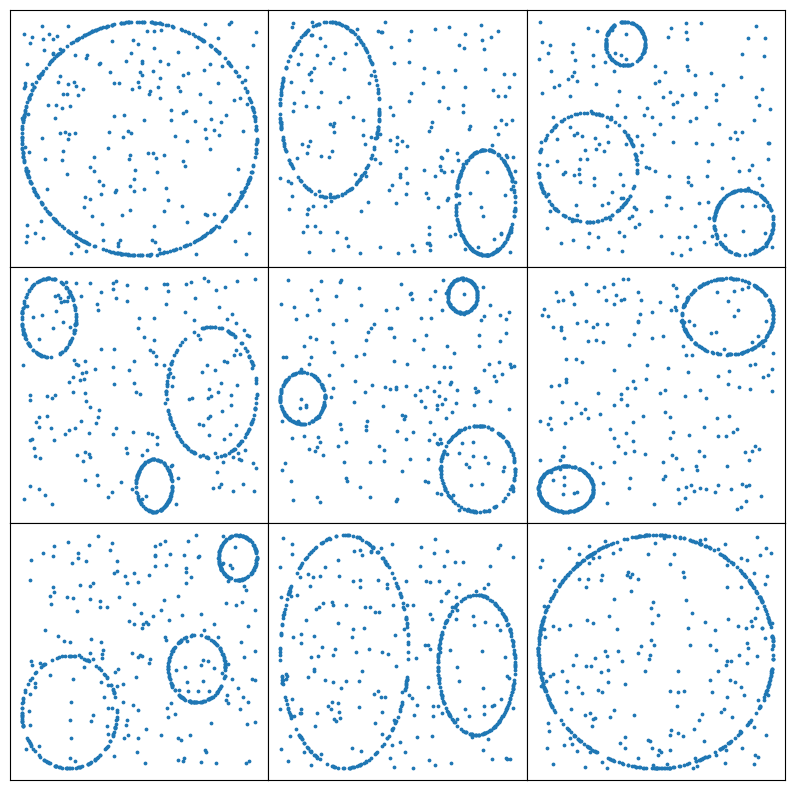

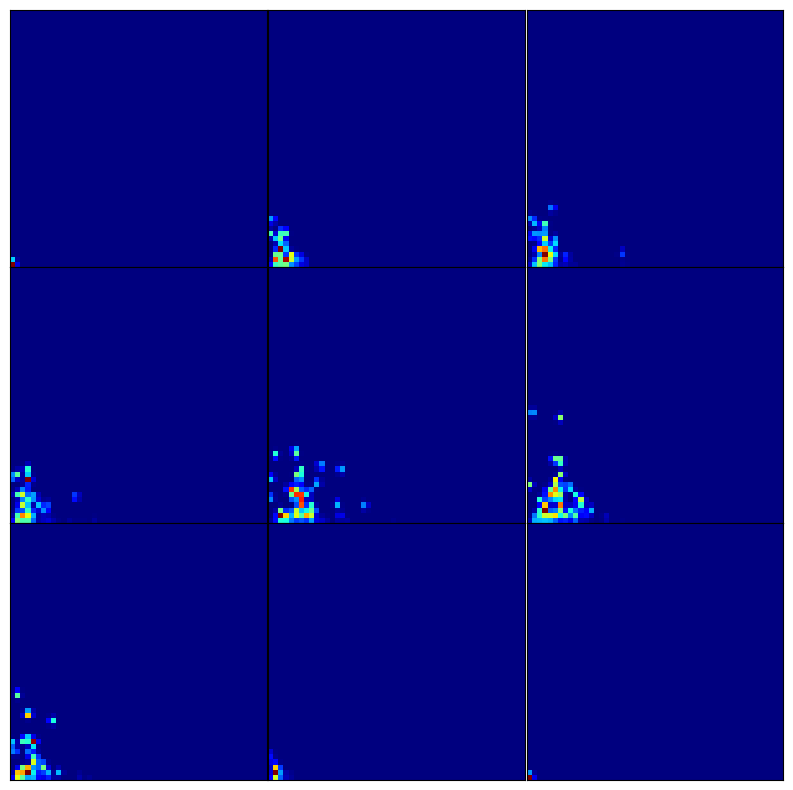

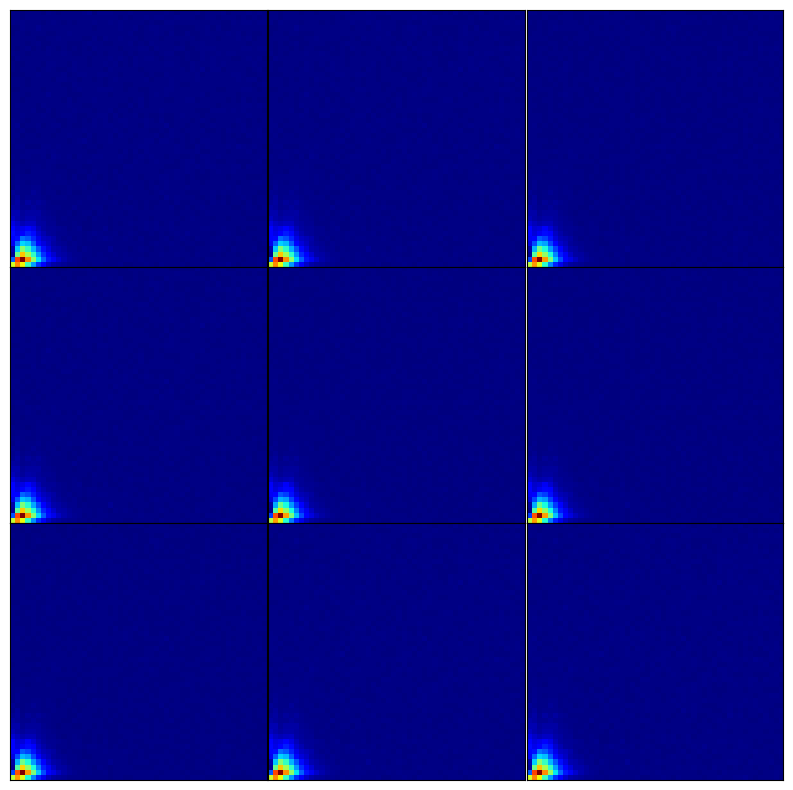

In [24]:
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.array(x)

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])

        try:
            data = to_numpy(tf_noisy_data_test[idx])
            if data.shape[1] != 2:
                print(f"Skipping idx={idx}, unexpected shape: {data.shape}")
                continue
            ax.scatter(data[:, 0], data[:, 1], s=3)
        except Exception as e:
            print(f"Error at idx={idx} in noisy point cloud: {e}")
            continue

        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("noisy_gudhi_pc.png", bbox_inches="tight")
print("Saved noisy_gudhi_pc.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])

        arr = np.array(noisy_PI_test[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue

        im = np.flip(arr.reshape(50, 50), 0)  # vertical flip
        ax.imshow(im, cmap="jet")
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("noisy_gudhi_pi.png", bbox_inches="tight")
print("Saved noisy_gudhi_pi.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])

        arr = np.array(noisy_PI_prediction[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue

        pred = np.flip(arr.reshape(50, 50), 0)
        ax.imshow(pred, cmap="jet")
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("noisy_ripsnet_pi.png", bbox_inches="tight")
print("Saved noisy_ripsnet_pi.png")


Yep, even though Gudhi now produces bad images because of the ambiant noise, RipsNet predictions still look rather good. Another way to quantify this is to see the difference between classifiers predicting the number of circles that are trained either from Gudhi or from RipsNet predictions. Let's first see how an XGBoost model performs when using Gudhi descriptors.

In [25]:
model_classif_gudhi = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_gudhi.fit(PI_train, label_classif_train)
clean_test_acc_gudhi = model_classif_gudhi.score(clean_PI_test, clean_label_classif_test)
noisy_test_acc_gudhi = model_classif_gudhi.score(noisy_PI_test, noisy_label_classif_test)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:53:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [26]:
print("Accuracy on clean test set = " + str(clean_test_acc_gudhi))
print("Accuracy on noisy test set = " + str(noisy_test_acc_gudhi))

Accuracy on clean test set = 0.33
Accuracy on noisy test set = 0.9


Well, the classifier definitely does well on clean data but struggles on noisy data. Let's see how another classifier trained on RipsNet descriptors now performs.

In [27]:
# ensure labels match the augmented training set size
# `le` was fitted earlier; label_train was augmented to match train inputs
label_classif_train_aug = le.transform(label_train)

model_classif_RN = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_RN.fit(train_PI_prediction, label_classif_train_aug)
clean_test_acc_RN = model_classif_RN.score(clean_PI_prediction, clean_label_classif_test)
noisy_test_acc_RN = model_classif_RN.score(noisy_PI_prediction, noisy_label_classif_test)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:53:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [28]:
print("Accuracy on clean test set = " + str(clean_test_acc_RN))
print("Accuracy on noisy test set = " + str(noisy_test_acc_RN))

Accuracy on clean test set = 0.59
Accuracy on noisy test set = 0.63


Well, even though the accuracy is slightly worse on clean data, it does remarkably well when noise is added! This illustrates the robustness of RipsNet-based topological descriptors.

Now, let's play the same game with persistence landscapes, using the same architecture (except for the dimension of the final layer of course). In the three following cells, we define RipsNet, train it on landscapes, and use it to predict persistence landscapes from the data.

In [29]:
output_dim = PL_train.shape[1]
model_PL = RaggedPersistenceModel(output_dim=output_dim)

optimizer = Adamax(model_PL.parameters(), lr=5e-4)
criterion = nn.MSELoss()

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_PL = model_PL.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adamax(model_PL.parameters(), lr=5e-4)

patience = 20
best_val_loss = float('inf')
patience_counter = 0
num_epochs = 10000

# prepare data once (move to device)
train_inputs = [x.to(device).float() if isinstance(x, torch.Tensor) else torch.tensor(x, dtype=torch.float32, device=device) for x in tf_data_train]
train_targets = torch.tensor(PL_train, dtype=torch.float32, device=device)

val_inputs = [x.to(device).float() if isinstance(x, torch.Tensor) else torch.tensor(x, dtype=torch.float32, device=device) for x in tf_clean_data_test]
val_targets = torch.tensor(clean_PL_test, dtype=torch.float32, device=device)

history = {'train_loss': [], 'val_loss': []}
best_model_state = {k: v.cpu() for k, v in model_PL.state_dict().items()}

for epoch in range(num_epochs):
    model_PL.train()
    optimizer.zero_grad()

    outputs = model_PL(train_inputs)
    if isinstance(outputs, (list, tuple)):
        outputs = outputs[0]
    if outputs is None:
        raise RuntimeError("model_PL returned None")
    if not isinstance(outputs, torch.Tensor):
        outputs = torch.tensor(outputs, dtype=train_targets.dtype, device=train_targets.device)
    else:
        outputs = outputs.to(train_targets.device).type(train_targets.dtype)

    loss = criterion(outputs, train_targets)
    loss.backward()
    optimizer.step()

    model_PL.eval()
    with torch.no_grad():
        val_outputs = model_PL(val_inputs)
        if isinstance(val_outputs, (list, tuple)):
            val_outputs = val_outputs[0]
        val_outputs = val_outputs.to(val_targets.device).type(val_targets.dtype)
        val_loss = criterion(val_outputs, val_targets)

    history['train_loss'].append(loss.item())
    history['val_loss'].append(val_loss.item())

    if val_loss.item() < best_val_loss - 1e-5:
        best_val_loss = val_loss.item()
        patience_counter = 0
        # save on CPU to avoid GPU memory hold
        best_model_state = {k: v.cpu().clone() for k, v in model_PL.state_dict().items()}
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {loss.item():.6f}, Val loss: {val_loss.item():.6f}")

# load best weights back to device
model_PL.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
print(f"Training complete. Best val_loss = {best_val_loss:.6f}")


/tmp/ipython-input-2479331243.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_targets = torch.tensor(PL_train, dtype=torch.float32, device=device)
/tmp/ipython-input-2479331243.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_targets = torch.tensor(clean_PL_test, dtype=torch.float32, device=device)


Epoch 50/10000 - Train loss: 0.132851, Val loss: 0.197442
Early stopping at epoch 99
Training complete. Best val_loss = 0.153241


In [31]:
model_PL.eval()

with torch.no_grad():
    train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
    clean_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
    noisy_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_noisy_data_test]

    train_PL_prediction = model_PL(train_inputs).cpu().numpy()
    clean_PL_prediction = model_PL(clean_inputs).cpu().numpy()
    noisy_PL_prediction = model_PL(noisy_inputs).cpu().numpy()

print("Predictions computed:")
print(f"train_PI_prediction shape: {train_PL_prediction.shape}")
print(f"clean_PI_prediction shape: {clean_PL_prediction.shape}")
print(f"noisy_PI_prediction shape: {noisy_PL_prediction.shape}")


/tmp/ipython-input-2552692517.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
/tmp/ipython-input-2552692517.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clean_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
/tmp/ipython-input-2552692517.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_noisy_data_test]


Predictions computed:
train_PI_prediction shape: (900, 1500)
clean_PI_prediction shape: (200, 1500)
noisy_PI_prediction shape: (200, 1500)


Let's see how good RipsNet is for landscapes now.

Saved clean_gudhi_pc.png
Skipping idx=0, unexpected size: 1500
Skipping idx=1, unexpected size: 1500
Skipping idx=2, unexpected size: 1500
Skipping idx=3, unexpected size: 1500
Skipping idx=4, unexpected size: 1500
Skipping idx=5, unexpected size: 1500
Skipping idx=6, unexpected size: 1500
Skipping idx=7, unexpected size: 1500
Skipping idx=8, unexpected size: 1500
Saved clean_gudhi_pl.png
Skipping idx=0, unexpected size: 1500
Skipping idx=1, unexpected size: 1500
Skipping idx=2, unexpected size: 1500
Skipping idx=3, unexpected size: 1500
Skipping idx=4, unexpected size: 1500
Skipping idx=5, unexpected size: 1500
Skipping idx=6, unexpected size: 1500
Skipping idx=7, unexpected size: 1500
Skipping idx=8, unexpected size: 1500
Saved clean_ripsnet_pl.png


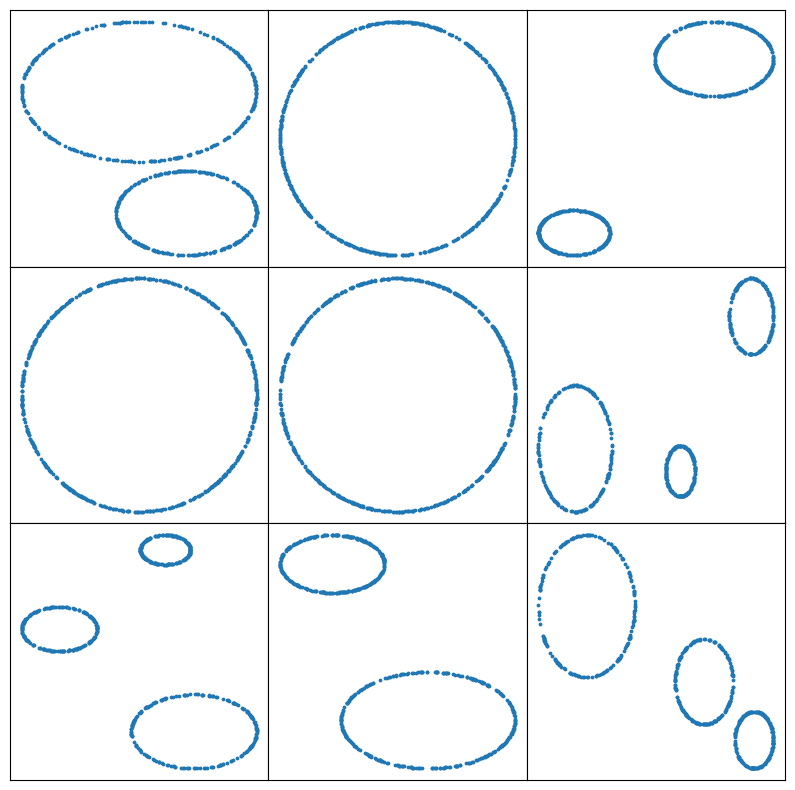

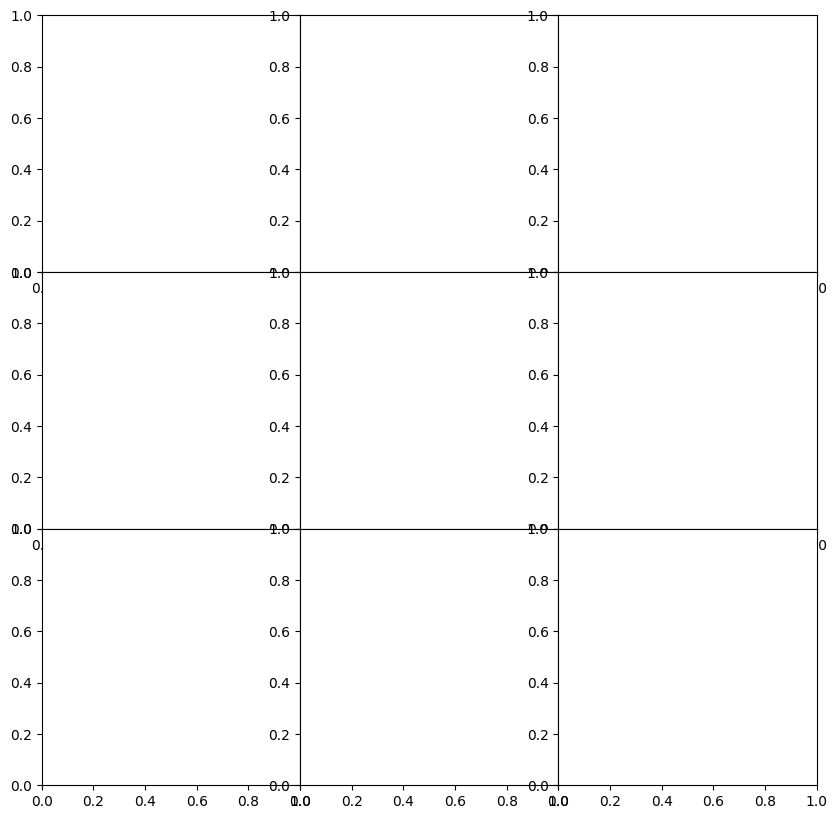

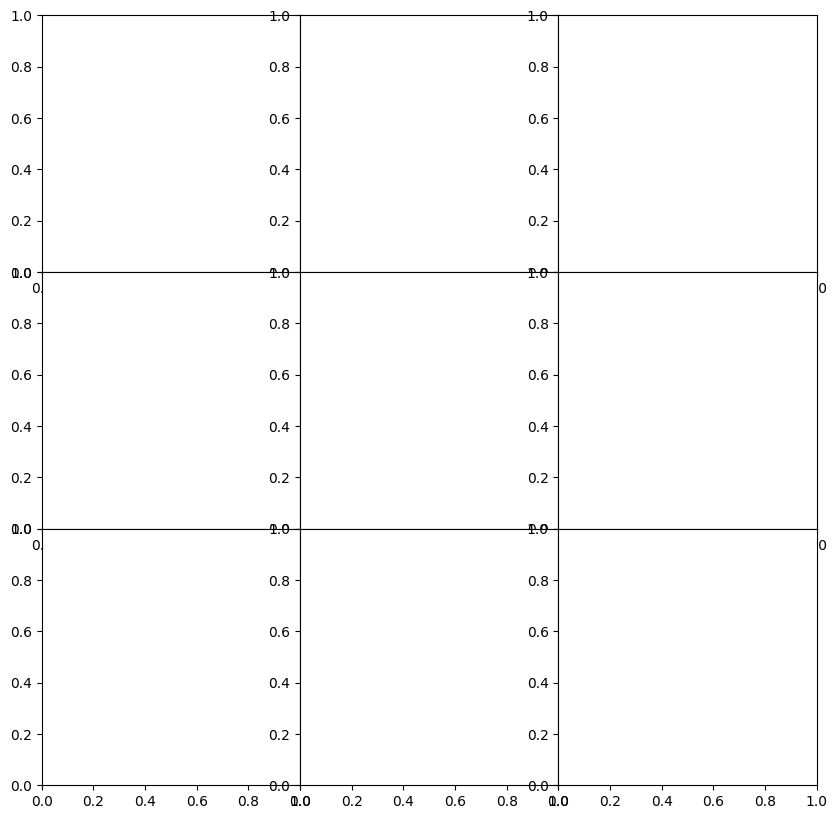

In [32]:
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.array(x)

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])

        try:
            data = to_numpy(tf_clean_data_test[idx])
            if data.shape[1] != 2:
                print(f"Skipping idx={idx}, unexpected shape: {data.shape}")
                continue
            ax.scatter(data[:, 0], data[:, 1], s=3)
        except Exception as e:
            print(f"Error at idx={idx} in point cloud: {e}")
            continue

        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig('clean_gudhi_pc.png', bbox_inches='tight')
print("Saved clean_gudhi_pc.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])

        arr = np.array(clean_PL_test[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue

        im = np.flip(arr.reshape(50, 50), 0)  # vertical flip
        ax.imshow(im, cmap='jet')
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig('clean_gudhi_pl.png', bbox_inches='tight')
print("Saved clean_gudhi_pl.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])

        arr = np.array(clean_PL_prediction[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue

        pred = np.flip(arr.reshape(50, 50), 0)
        ax.imshow(pred, cmap='jet')
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig('clean_ripsnet_pl.png', bbox_inches='tight')
print("Saved clean_ripsnet_pl.png")


Saved noisy_gudhi_pc.png
Skipping idx=0, unexpected size: 1500
Skipping idx=1, unexpected size: 1500
Skipping idx=2, unexpected size: 1500
Skipping idx=3, unexpected size: 1500
Skipping idx=4, unexpected size: 1500
Skipping idx=5, unexpected size: 1500
Skipping idx=6, unexpected size: 1500
Skipping idx=7, unexpected size: 1500
Skipping idx=8, unexpected size: 1500
Saved noisy_gudhi_pl.png
Skipping idx=0, unexpected size: 1500
Skipping idx=1, unexpected size: 1500
Skipping idx=2, unexpected size: 1500
Skipping idx=3, unexpected size: 1500
Skipping idx=4, unexpected size: 1500
Skipping idx=5, unexpected size: 1500
Skipping idx=6, unexpected size: 1500
Skipping idx=7, unexpected size: 1500
Skipping idx=8, unexpected size: 1500
Saved noisy_ripsnet_pl.png


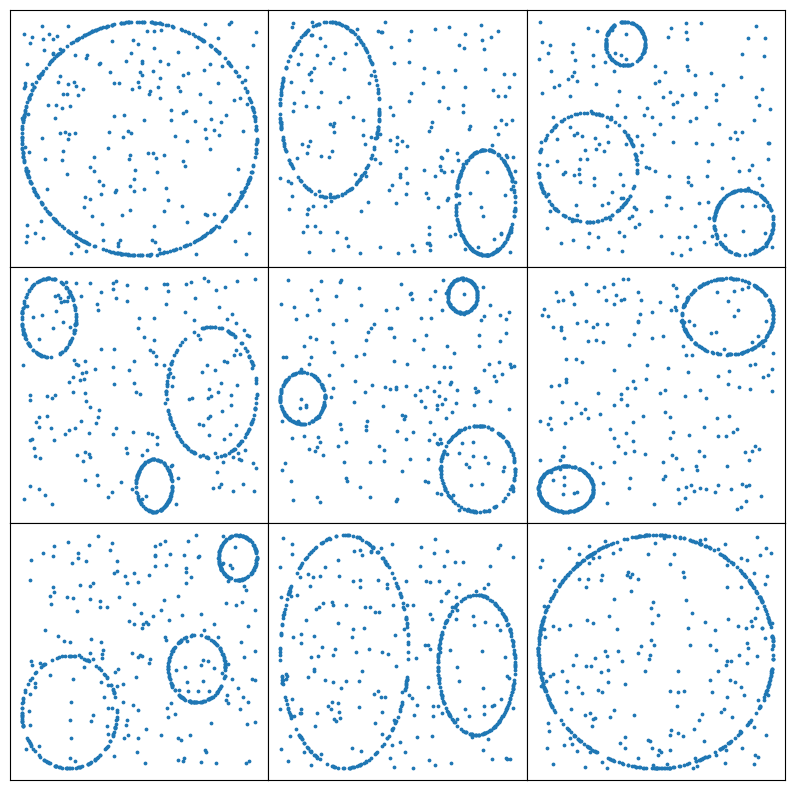

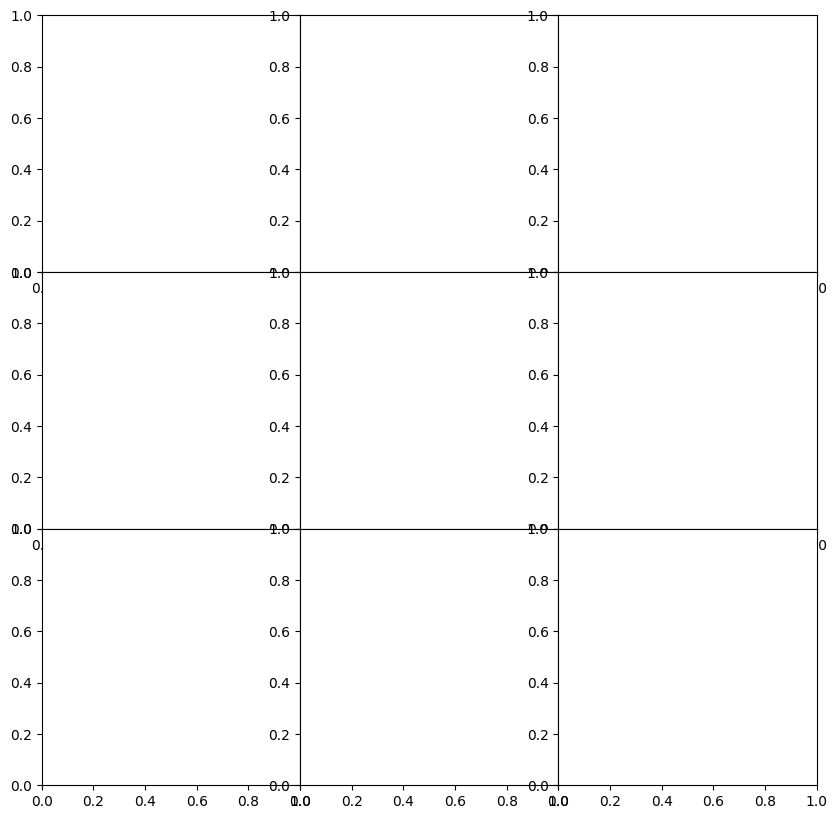

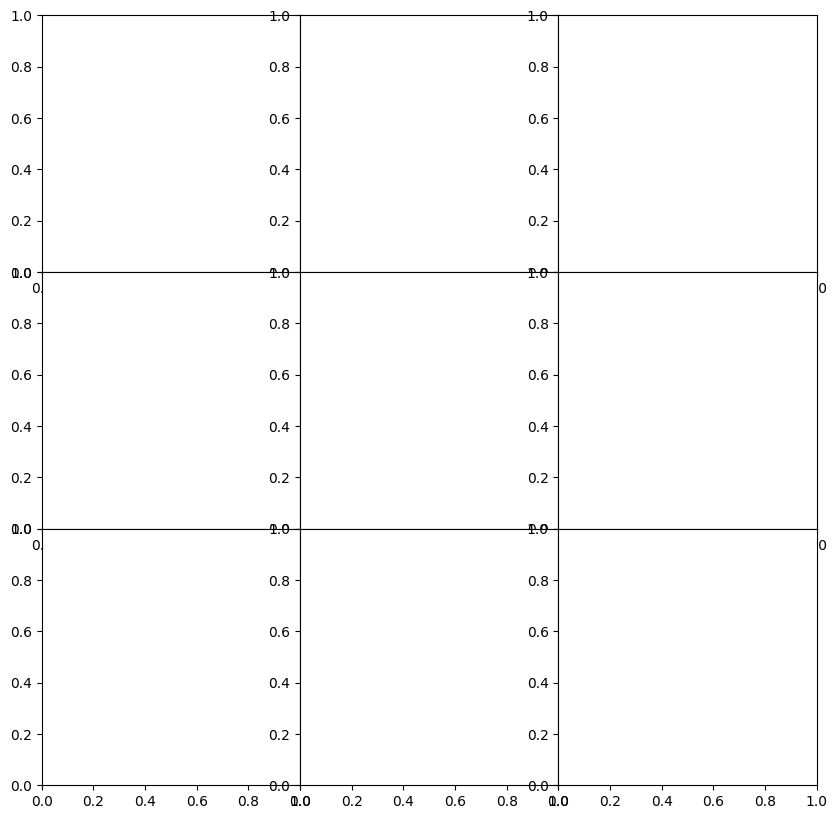

In [33]:
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.array(x)

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])

        try:
            data = to_numpy(tf_noisy_data_test[idx])
            if data.shape[1] != 2:
                print(f"Skipping idx={idx}, unexpected shape: {data.shape}")
                continue
            ax.scatter(data[:, 0], data[:, 1], s=3)
        except Exception as e:
            print(f"Error at idx={idx} in noisy point cloud: {e}")
            continue

        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("noisy_gudhi_pc.png", bbox_inches="tight")
print("Saved noisy_gudhi_pc.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])

        arr = np.array(noisy_PL_test[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue

        im = np.flip(arr.reshape(50, 50), 0)  # vertical flip
        ax.imshow(im, cmap="jet")
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("noisy_gudhi_pl.png", bbox_inches="tight")
print("Saved noisy_gudhi_pl.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])

        arr = np.array(noisy_PL_prediction[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue

        pred = np.flip(arr.reshape(50, 50), 0)
        ax.imshow(pred, cmap="jet")
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("noisy_ripsnet_pl.png", bbox_inches="tight")
print("Saved noisy_ripsnet_pl.png")


As before, we end by training XGBoost classifier on both Gudhi and RipsNet generated landscapes.

In [34]:
model_classif_gudhi = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_gudhi.fit(PL_train, label_classif_train)
clean_test_acc_gudhi = model_classif_gudhi.score(clean_PL_test,  clean_label_classif_test)
noisy_test_acc_gudhi = model_classif_gudhi.score(noisy_PL_test,  noisy_label_classif_test)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:55:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [35]:
print("Accuracy on clean test set = " + str(clean_test_acc_gudhi))
print("Accuracy on noisy test set = " + str(noisy_test_acc_gudhi))

Accuracy on clean test set = 0.535
Accuracy on noisy test set = 0.915


In [36]:
model_classif_RN = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_RN.fit(train_PL_prediction, label_classif_train)
clean_test_acc_RN = model_classif_RN.score(clean_PL_prediction, clean_label_classif_test)
noisy_test_acc_RN = model_classif_RN.score(noisy_PL_prediction, noisy_label_classif_test)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:55:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [37]:
print("Accuracy on clean test set = " + str(clean_test_acc_RN))
print("Accuracy on noisy test set = " + str(noisy_test_acc_RN))

Accuracy on clean test set = 0.72
Accuracy on noisy test set = 0.645


The difference is less clear than for persistence images, but present nonetheless! Again, RipsNet exhibits better  robustness properties than Gudhi on noise data, while being faster and almost as good on clean data.

# Task
Compute pairwise Euclidean distance matrices for the training and test point clouds, then initialize and train a DistanceMatrixRaggedModel to predict Persistence Images. Afterwards, evaluate its classification accuracy using an XGBoost classifier on clean and noisy test sets. Repeat this process for Persistence Landscapes.

In [38]:
import torch
import torch.nn as nn
from typing import List

class DistanceMatrixRaggedModel(nn.Module):
    def __init__(self, output_dim, num_points=None, phi_dim=128, rho_hidden=(256,128)):
        """
        output_dim: final descriptor size (e.g., PI_train.shape[1])
        num_points: expected number of points (row length). If None, model infers size at first forward.
        phi_dim: per-row embedding size
        rho_hidden: sizes of hidden layers for global map
        """
        super().__init__()
        self.num_points = num_points
        inp = num_points if num_points is not None else 0
        self._phi_layers = None
        self.phi_dim = phi_dim
        self._build_phi(inp)
        layers = []
        prev = phi_dim
        for h in rho_hidden:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            prev = h
        layers.append(nn.Linear(prev, output_dim))
        self.rho = nn.Sequential(*layers)

    def _build_phi(self, inp):
        if inp <= 0:
            self._phi_layers = None
            return
        hidden = max(64, self.phi_dim)
        self._phi_layers = nn.Sequential(
            nn.Linear(inp, hidden),
            nn.ReLU(),
            nn.Linear(hidden, self.phi_dim),
            nn.ReLU()
        )

    def forward(self, batch: List[torch.Tensor]):
        """
        batch: list of (Ni x Ni) distance matrices (torch.Tensor)
        returns: (B, output_dim)
        """
        if len(batch) == 0:
            return torch.empty(0, self.rho[-1].out_features, device=next(self.parameters()).device)

        sizes = [m.shape[0] for m in batch]
        max_n = max(sizes)
        device = next(self.parameters()).device

        if self._phi_layers is None or (self.num_points and self.num_points != max_n):
            self._build_phi(max_n)
            self.num_points = max_n
            self._phi_layers = self._phi_layers.to(device)

        B = len(batch)
        mats = torch.zeros((B, max_n, max_n), dtype=torch.float32, device=device)
        row_mask = torch.zeros((B, max_n), dtype=torch.bool, device=device)
        for i, m in enumerate(batch):
            n = m.shape[0]
            mats[i, :n, :n] = m.to(device).float()
            row_mask[i, :n] = 1

        rows = mats.reshape(B * max_n, max_n)
        phi_out = self._phi_layers(rows)
        phi_out = phi_out.reshape(B, max_n, -1)

        lengths = row_mask.sum(dim=1).clamp(min=1).unsqueeze(-1).float()
        summed = (phi_out * row_mask.unsqueeze(-1).float()).sum(dim=1)
        aggregated = summed / lengths

        out = self.rho(aggregated)
        return out


## Compute distance matrices

Compute pairwise Euclidean distance matrices for the training and test point clouds.


In [39]:
dm_train = []
for X in tqdm(data_train, desc='Computing DM for training data'):
    dm_train.append(distance_matrix(X))

dm_clean_test = []
for X in tqdm(clean_data_test, desc='Computing DM for clean test data'):
    dm_clean_test.append(distance_matrix(X))

dm_noisy_test = []
for X in tqdm(noisy_data_test, desc='Computing DM for noisy test data'):
    dm_noisy_test.append(distance_matrix(X))

print(f"Shape of first training distance matrix: {dm_train[0].shape}")
print(f"Shape of first clean test distance matrix: {dm_clean_test[0].shape}")
print(f"Shape of first noisy test distance matrix: {dm_noisy_test[0].shape}")

Computing DM for noisy test data: 100%|██████████| 200/200 [00:03<00:00, 52.78it/s]

Shape of first training distance matrix: (600, 600)
Shape of first clean test distance matrix: (600, 600)
Shape of first noisy test distance matrix: (600, 600)


In [40]:
dm_train = []
for X in tqdm(data_train, desc='Computing DM for training data'):
    dm_train.append(distance_matrix(X))

dm_clean_test = []
for X in tqdm(clean_data_test, desc='Computing DM for clean test data'):
    dm_clean_test.append(distance_matrix(X))

dm_noisy_test = []
for X in tqdm(noisy_data_test, desc='Computing DM for noisy test data'):
    dm_noisy_test.append(distance_matrix(X))

print(f"Shape of first training distance matrix: {dm_train[0].shape}")
print(f"Shape of first clean test distance matrix: {dm_clean_test[0].shape}")
print(f"Shape of first noisy test distance matrix: {dm_noisy_test[0].shape}")

Computing DM for noisy test data: 100%|██████████| 200/200 [00:04<00:00, 46.09it/s]

Shape of first training distance matrix: (600, 600)
Shape of first clean test distance matrix: (600, 600)
Shape of first noisy test distance matrix: (600, 600)


In [41]:
output_dim_pi = PI_train.shape[1]
model_dm_pi = DistanceMatrixRaggedModel(output_dim=output_dim_pi)

print(f"Initialized DistanceMatrixRaggedModel for PI with output_dim: {output_dim_pi}")

Initialized DistanceMatrixRaggedModel for PI with output_dim: 2500


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dm_pi.to(device)
criterion = nn.MSELoss()
optimizer = Adamax(model_dm_pi.parameters(), lr=5e-4)

# Ensure num_epochs is defined
try:
    num_epochs
except NameError:
    num_epochs = 10000

model_dm_pi, history_dm_pi, best_model_state_dm_pi = train_model(
    model_dm_pi, optimizer, criterion,
    dm_train, PI_train,
    dm_clean_test, clean_PI_test,
    epochs=num_epochs, batch_size=32
)

best_val_loss_dm_pi = min(history_dm_pi['val_loss']) if history_dm_pi.get('val_loss') else float('inf')
print(f"Training DistanceMatrixRaggedModel for PI complete. Best val_loss = {best_val_loss_dm_pi:.6f}")

Epoch 1/10000, Train Loss: 0.004219, Val Loss: 0.001882
Epoch 2/10000, Train Loss: 0.001798, Val Loss: 0.001019
Epoch 3/10000, Train Loss: 0.000995, Val Loss: 0.000511
Epoch 4/10000, Train Loss: 0.000610, Val Loss: 0.000329
Epoch 5/10000, Train Loss: 0.000464, Val Loss: 0.000284
Epoch 6/10000, Train Loss: 0.000404, Val Loss: 0.000256
Epoch 7/10000, Train Loss: 0.000370, Val Loss: 0.000254
Epoch 8/10000, Train Loss: 0.000347, Val Loss: 0.000257
Epoch 9/10000, Train Loss: 0.000328, Val Loss: 0.000265
Epoch 10/10000, Train Loss: 0.000313, Val Loss: 0.000241
Epoch 11/10000, Train Loss: 0.000304, Val Loss: 0.000249
Epoch 12/10000, Train Loss: 0.000292, Val Loss: 0.000251
Epoch 13/10000, Train Loss: 0.000284, Val Loss: 0.000253
Epoch 14/10000, Train Loss: 0.000276, Val Loss: 0.000258
Epoch 15/10000, Train Loss: 0.000268, Val Loss: 0.000258
Epoch 16/10000, Train Loss: 0.000262, Val Loss: 0.000253
Epoch 17/10000, Train Loss: 0.000255, Val Loss: 0.000250
Epoch 18/10000, Train Loss: 0.000249, Va

## Evaluate classification accuracy (PI)

Make predictions with the trained `DistanceMatrixRaggedModel` for Persistence Images on clean and noisy test sets. Then, train an XGBoost classifier on these predictions and report the classification accuracy.


In [43]:
model_dm_pi.eval()

with torch.no_grad():
    dm_train_tensor = [torch.tensor(dm, dtype=torch.float32).to(device) for dm in dm_train]
    dm_clean_test_tensor = [torch.tensor(dm, dtype=torch.float32).to(device) for dm in dm_clean_test]
    dm_noisy_test_tensor = [torch.tensor(dm, dtype=torch.float32).to(device) for dm in dm_noisy_test]

    dm_train_PI_prediction = model_dm_pi(dm_train_tensor).cpu().numpy()
    dm_clean_PI_prediction = model_dm_pi(dm_clean_test_tensor).cpu().numpy()
    dm_noisy_PI_prediction = model_dm_pi(dm_noisy_test_tensor).cpu().numpy()

print("Predictions computed for DistanceMatrixRaggedModel for PI:")
print(f"dm_train_PI_prediction shape: {dm_train_PI_prediction.shape}")
print(f"dm_clean_PI_prediction shape: {dm_clean_PI_prediction.shape}")
print(f"dm_noisy_PI_prediction shape: {dm_noisy_PI_prediction.shape}")

# Train an XGBoost classifier on the predictions
model_classif_dm_pi = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_dm_pi.fit(dm_train_PI_prediction, label_classif_train)

# Evaluate accuracy on clean test set
clean_test_acc_dm_pi = model_classif_dm_pi.score(dm_clean_PI_prediction, clean_label_classif_test)
print(f"Accuracy on clean test set : {clean_test_acc_dm_pi}")

# Evaluate accuracy on noisy test set
noisy_test_acc_dm_pi = model_classif_dm_pi.score(dm_noisy_PI_prediction, noisy_label_classif_test)
print(f"Accuracy on noisy test set : {noisy_test_acc_dm_pi}")

Predictions computed for DistanceMatrixRaggedModel for PI:
dm_train_PI_prediction shape: (900, 2500)
dm_clean_PI_prediction shape: (200, 2500)
dm_noisy_PI_prediction shape: (200, 2500)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:01:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy on clean test set : 0.74
Accuracy on noisy test set : 0.695


In [44]:
model_dm_pi.eval()

with torch.no_grad():
    dm_train_tensor = [torch.tensor(dm, dtype=torch.float32).to(device) for dm in dm_train]
    dm_clean_test_tensor = [torch.tensor(dm, dtype=torch.float32).to(device) for dm in dm_clean_test]
    dm_noisy_test_tensor = [torch.tensor(dm, dtype=torch.float32).to(device) for dm in dm_noisy_test]

    dm_train_PI_prediction = model_dm_pi(dm_train_tensor).cpu().numpy()
    dm_clean_PI_prediction = model_dm_pi(dm_clean_test_tensor).cpu().numpy()
    dm_noisy_PI_prediction = model_dm_pi(dm_noisy_test_tensor).cpu().numpy()

print("Predictions computed for DistanceMatrixRaggedModel for PI:")
print(f"dm_train_PI_prediction shape: {dm_train_PI_prediction.shape}")
print(f"dm_clean_PI_prediction shape: {dm_clean_PI_prediction.shape}")
print(f"dm_noisy_PI_prediction shape: {dm_noisy_PI_prediction.shape}")

# Train an XGBoost classifier on the predictions
model_classif_dm_pi = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_dm_pi.fit(dm_train_PI_prediction, label_classif_train)

# Evaluate accuracy on clean test set
clean_test_acc_dm_pi = model_classif_dm_pi.score(dm_clean_PI_prediction, clean_label_classif_test)
print(f"Accuracy on clean test set (DistanceMatrixRaggedModel for PI): {clean_test_acc_dm_pi}")

# Evaluate accuracy on noisy test set
noisy_test_acc_dm_pi = model_classif_dm_pi.score(dm_noisy_PI_prediction, noisy_label_classif_test)
print(f"Accuracy on noisy test set (DistanceMatrixRaggedModel for PI): {noisy_test_acc_dm_pi}")

Predictions computed for DistanceMatrixRaggedModel for PI:
dm_train_PI_prediction shape: (900, 2500)
dm_clean_PI_prediction shape: (200, 2500)
dm_noisy_PI_prediction shape: (200, 2500)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:02:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy on clean test set (DistanceMatrixRaggedModel for PI): 0.74
Accuracy on noisy test set (DistanceMatrixRaggedModel for PI): 0.695


## Train DistanceMatrixRaggedModel for Persistence Landscapes

Initialize, train, and make predictions with a new `DistanceMatrixRaggedModel` using the computed distance matrices and Persistence Landscapes as targets.


In [45]:
output_dim_pi = PI_train.shape[1]
model_dm_pi = DistanceMatrixRaggedModel(output_dim=output_dim_pi)

print(f"Initialized DistanceMatrixRaggedModel for PI with output_dim: {output_dim_pi}")

Initialized DistanceMatrixRaggedModel for PI with output_dim: 2500


In [ ]:
output_dim_pl = PL_train.shape[1]
model_dm_pl = DistanceMatrixRaggedModel(output_dim=output_dim_pl)

print(f"Initialized DistanceMatrixRaggedModel for PL with output_dim: {output_dim_pl}")

model_dm_pl.to(device)
criterion_pl = nn.MSELoss()
optimizer_pl = Adamax(model_dm_pl.parameters(), lr=5e-4)

# Ensure num_epochs is defined
try:
    num_epochs
except NameError:
    num_epochs = 10000

model_dm_pl, history_dm_pl, best_model_state_dm_pl = train_model(
    model_dm_pl, optimizer_pl, criterion_pl,
    dm_train, PL_train,
    dm_clean_test, clean_PL_test,
    epochs=num_epochs, batch_size=32
)

best_val_loss_dm_pl = min(history_dm_pl['val_loss']) if history_dm_pl.get('val_loss') else float('inf')
print(f"Training DistanceMatrixRaggedModel for PL complete. Best val_loss = {best_val_loss_dm_pl:.6f}")

model_dm_pl.eval()

with torch.no_grad():
    # Ensure inputs are on the correct device and dtype for prediction
    dm_train_tensor_pl = [torch.tensor(dm, dtype=torch.float32).to(device) for dm in dm_train]
    dm_clean_test_tensor_pl = [torch.tensor(dm, dtype=torch.float32).to(device) for dm in dm_clean_test]
    dm_noisy_test_tensor_pl = [torch.tensor(dm, dtype=torch.float32).to(device) for dm in dm_noisy_test]

    dm_train_PL_prediction = model_dm_pl(dm_train_tensor_pl).cpu().numpy()
    dm_clean_PL_prediction = model_dm_pl(dm_clean_test_tensor_pl).cpu().numpy()
    dm_noisy_PL_prediction = model_dm_pl(dm_noisy_test_tensor_pl).cpu().numpy()

print("Predictions computed for DistanceMatrixRaggedModel for PL:")
print(f"dm_train_PL_prediction shape: {dm_train_PL_prediction.shape}")
print(f"dm_clean_PL_prediction shape: {dm_clean_PL_prediction.shape}")
print(f"dm_noisy_PL_prediction shape: {dm_noisy_PL_prediction.shape}")

Initialized DistanceMatrixRaggedModel for PL with output_dim: 1500
Epoch 1/10000, Train Loss: 0.008519, Val Loss: 0.179449
Epoch 2/10000, Train Loss: 0.004592, Val Loss: 0.176888
Epoch 3/10000, Train Loss: 0.003651, Val Loss: 0.174436
Epoch 4/10000, Train Loss: 0.002893, Val Loss: 0.172340
Epoch 5/10000, Train Loss: 0.002398, Val Loss: 0.171242
Epoch 6/10000, Train Loss: 0.002115, Val Loss: 0.170081
Epoch 7/10000, Train Loss: 0.001955, Val Loss: 0.169505
Epoch 8/10000, Train Loss: 0.001866, Val Loss: 0.169612
Epoch 9/10000, Train Loss: 0.001795, Val Loss: 0.169495
Epoch 10/10000, Train Loss: 0.001725, Val Loss: 0.169273
Epoch 11/10000, Train Loss: 0.001668, Val Loss: 0.169148
Epoch 12/10000, Train Loss: 0.001630, Val Loss: 0.169366
Epoch 13/10000, Train Loss: 0.001583, Val Loss: 0.168897
Epoch 14/10000, Train Loss: 0.001551, Val Loss: 0.169280
Epoch 15/10000, Train Loss: 0.001520, Val Loss: 0.169046
Epoch 16/10000, Train Loss: 0.001488, Val Loss: 0.168690
Epoch 17/10000, Train Loss: 0.

In [ ]:
model_dm_pl.eval()

with torch.no_grad():
    dm_train_tensor = [torch.tensor(dm, dtype=torch.float32).to(device) for dm in dm_train]
    dm_clean_test_tensor = [torch.tensor(dm, dtype=torch.float32).to(device) for dm in dm_clean_test]
    dm_noisy_test_tensor = [torch.tensor(dm, dtype=torch.float32).to(device) for dm in dm_noisy_test]

    dm_train_PL_prediction = model_dm_pl(dm_train_tensor).cpu().numpy()
    dm_clean_PL_prediction = model_dm_pl(dm_clean_test_tensor).cpu().numpy()
    dm_noisy_PL_prediction = model_dm_pl(dm_noisy_test_tensor).cpu().numpy()

print("Predictions computed for DistanceMatrixRaggedModel for PL:")
print(f"dm_train_PL_prediction shape: {dm_train_PL_prediction.shape}")
print(f"dm_clean_PL_prediction shape: {dm_clean_PL_prediction.shape}")
print(f"dm_noisy_PL_prediction shape: {dm_noisy_PL_prediction.shape}")

# Train an XGBoost classifier on the predictions
model_classif_dm_pl = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_dm_pl.fit(dm_train_PL_prediction, label_classif_train)

# Evaluate accuracy on clean test set
clean_test_acc_dm_pl = model_classif_dm_pl.score(dm_clean_PL_prediction, clean_label_classif_test)
print(f"Accuracy on clean test set (DistanceMatrixRaggedModel for PI): {clean_test_acc_dm_pi}")

# Evaluate accuracy on noisy test set
noisy_test_acc_dm_pl = model_classif_dm_pl.score(dm_noisy_PL_prediction, noisy_label_classif_test)
print(f"Accuracy on noisy test set (DistanceMatrixRaggedModel for PI): {noisy_test_acc_dm_pi}")

## Define PointNet Model Class

### Subtask:
Create a new `nn.Module` class named `PointNet` that implements a PointNet-like architecture, accepting a list of 2D point clouds, padding them internally, processing with shared MLPs and max-pooling, and outputting a fixed-size vector.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from typing import List

class PointNet(nn.Module):
    def __init__(self, output_dim, phi_dims=[64, 128, 256], rho_dims=[256, 128]):
        super().__init__()

        # Phi function (shared MLP) - maps each point to a feature vector
        phi_layers = []
        in_features = 2 # 2D points
        for dim in phi_dims:
            phi_layers.append(nn.Linear(in_features, dim))
            phi_layers.append(nn.ReLU())
            in_features = dim
        self.phi_layers = nn.Sequential(*phi_layers)

        # Rho function (global MLP) - processes aggregated features
        rho_layers = []
        in_features = phi_dims[-1] # Input to rho is the max-pooled feature from phi
        for dim in rho_dims:
            rho_layers.append(nn.Linear(in_features, dim))
            rho_layers.append(nn.ReLU())
            in_features = dim
        rho_layers.append(nn.Linear(in_features, output_dim))
        # No activation on the final layer for regression tasks
        self.rho_layers = nn.Sequential(*rho_layers)

    def forward(self, batch: List[torch.Tensor]):
        if len(batch) == 0:
            # Return an empty tensor with the correct output dimension if batch is empty
            return torch.empty(0, self.rho_layers[-1].out_features, device=next(self.parameters()).device)

        # Pad point clouds to the maximum length in the batch
        # `pad_sequence` expects a list of tensors of shape (L, *) where L is sequence length
        padded_batch = pad_sequence(batch, batch_first=True, padding_value=0.0)
        # original_lengths = [len(pc) for pc in batch]

        # Create a mask for valid points
        # Shape: (batch_size, max_num_points)
        mask = torch.zeros(padded_batch.shape[0], padded_batch.shape[1], dtype=torch.bool, device=padded_batch.device)
        for i, pc in enumerate(batch):
            mask[i, :len(pc)] = True

        # Apply shared MLP (phi function) to all points
        # Reshape to (total_num_points_in_batch, input_dim) for MLP, then reshape back
        # phi_out shape: (batch_size, max_num_points, phi_dims[-1])
        phi_out = self.phi_layers(padded_batch.view(-1, padded_batch.shape[-1]))
        phi_out = phi_out.view(padded_batch.shape[0], padded_batch.shape[1], -1)

        # Apply mask before max-pooling
        # Set features of padded points to a very small negative value
        # so they don't affect the max operation (especially with ReLU later in rho)
        min_val = torch.finfo(phi_out.dtype).min
        masked_phi_out = phi_out.masked_fill(~mask.unsqueeze(-1), min_val)

        # Permutation-invariant aggregation (max-pooling over points)
        # aggregated_features shape: (batch_size, phi_dims[-1])
        aggregated_features, _ = torch.max(masked_phi_out, dim=1)

        # Apply global MLP (rho function)
        # output shape: (batch_size, output_dim)
        output = self.rho_layers(aggregated_features)

        return output

print("PointNet class defined.")

## Initialize and Train PointNet for Persistence Images

### Subtask:
Initialize an instance of the `PointNet` model with `output_dim` set to match the dimension of `PI_train`. Configure `MSELoss` as the criterion and `Adamax` as the optimizer. Then, train the `PointNet` model using `tf_data_train` (the original point clouds) as inputs and `PI_train` as targets. Use `tf_clean_data_test` and `clean_PI_test` for validation, leveraging the `train_model` helper function.


In [ ]:
output_dim_pi_pn = PI_train.shape[1]
model_PN_PI = PointNet(output_dim=output_dim_pi_pn)

print(f"Initialized PointNet for PI with output_dim: {output_dim_pi_pn}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_PN_PI.to(device)
criterion_pn = nn.MSELoss()
optimizer_pn = Adamax(model_PN_PI.parameters(), lr=5e-4)

# Ensure num_epochs is defined
try:
    num_epochs
except NameError:
    num_epochs = 10000

model_PN_PI, history_PN_PI, best_model_state_pn_pi = train_model(
    model_PN_PI, optimizer_pn, criterion_pn,
    tf_data_train, PI_train,
    tf_clean_data_test, clean_PI_test,
    epochs=num_epochs, batch_size=32
)

best_val_loss_pn_pi = min(history_PN_PI['val_loss']) if history_PN_PI.get('val_loss') else float('inf')
print(f"Training PointNet for PI complete. Best val_loss = {best_val_loss_pn_pi:.6f}")

In [ ]:
model_PN_PI.eval()

with torch.no_grad():
    # Ensure inputs are on the correct device and dtype
    tf_data_train_tensor = [torch.tensor(pc, dtype=torch.float32).to(device) for pc in tf_data_train]
    tf_clean_data_test_tensor = [torch.tensor(pc, dtype=torch.float32).to(device) for pc in tf_clean_data_test]
    tf_noisy_data_test_tensor = [torch.tensor(pc, dtype=torch.float32).to(device) for pc in tf_noisy_data_test]

    pn_train_PI_prediction = model_PN_PI(tf_data_train_tensor).cpu().numpy()
    pn_clean_PI_prediction = model_PN_PI(tf_clean_data_test_tensor).cpu().numpy()
    pn_noisy_PI_prediction = model_PN_PI(tf_noisy_data_test_tensor).cpu().numpy()

print("Predictions computed for PointNet for PI:")
print(f"pn_train_PI_prediction shape: {pn_train_PI_prediction.shape}")
print(f"pn_clean_PI_prediction shape: {pn_clean_PI_prediction.shape}")
print(f"pn_noisy_PI_prediction shape: {pn_noisy_PI_prediction.shape}")

# Train an XGBoost classifier on the predictions from PointNet (PI)
model_classif_PN_PI = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_PN_PI.fit(pn_train_PI_prediction, label_classif_train)

# Evaluate accuracy on clean test set
clean_test_acc_PN_PI = model_classif_PN_PI.score(pn_clean_PI_prediction, clean_label_classif_test)
print(f"Accuracy on clean test set (PointNet for PI): {clean_test_acc_PN_PI}")

# Evaluate accuracy on noisy test set
noisy_test_acc_PN_PI = model_classif_PN_PI.score(pn_noisy_PI_prediction, noisy_label_classif_test)
print(f"Accuracy on noisy test set (PointNet for PI): {noisy_test_acc_PN_PI}")

In [ ]:
output_dim_pl_pn = PL_train.shape[1]
model_PN_PL = PointNet(output_dim=output_dim_pl_pn)

print(f"Initialized PointNet for PL with output_dim: {output_dim_pl_pn}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_PN_PL.to(device)
criterion_pn_pl = nn.MSELoss()
optimizer_pn_pl = Adamax(model_PN_PL.parameters(), lr=5e-4)

# Ensure num_epochs is defined
try:
    num_epochs
except NameError:
    num_epochs = 10000

model_PN_PL, history_PN_PL, best_model_state_pn_pl = train_model(
    model_PN_PL, optimizer_pn_pl, criterion_pn_pl,
    tf_data_train, PL_train,
    tf_clean_data_test, clean_PL_test,
    epochs=num_epochs, batch_size=32
)

best_val_loss_pn_pl = min(history_PN_PL['val_loss']) if history_PN_PL.get('val_loss') else float('inf')
print(f"Training PointNet for PL complete. Best val_loss = {best_val_loss_pn_pl:.6f}")

model_PN_PL.eval()

with torch.no_grad():
    # Ensure inputs are on the correct device and dtype
    tf_data_train_on_device = [pc.to(device) for pc in tf_data_train]
    tf_clean_data_test_on_device = [pc.to(device) for pc in tf_clean_data_test]
    tf_noisy_data_test_on_device = [pc.to(device) for pc in tf_noisy_data_test]

    pn_train_PL_prediction = model_PN_PL(tf_data_train_on_device).cpu().numpy()
    pn_clean_PL_prediction = model_PN_PL(tf_clean_data_test_on_device).cpu().numpy()
    pn_noisy_PL_prediction = model_PN_PL(tf_noisy_data_test_on_device).cpu().numpy()

print("Predictions computed for PointNet for PL:")
print(f"pn_train_PL_prediction shape: {pn_train_PL_prediction.shape}")
print(f"pn_clean_PL_prediction shape: {pn_clean_PL_prediction.shape}")
print(f"pn_noisy_PL_prediction shape: {pn_noisy_PL_prediction.shape}")

In [ ]:
model_classif_PN_PL = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_PN_PL.fit(pn_train_PL_prediction, label_classif_train)

# Evaluate accuracy on clean test set
clean_test_acc_PN_PL = model_classif_PN_PL.score(pn_clean_PL_prediction, clean_label_classif_test)
print(f"Accuracy on clean test set (PointNet for PL): {clean_test_acc_PN_PL}")

# Evaluate accuracy on noisy test set
noisy_test_acc_PN_PL = model_classif_PN_PL.score(pn_noisy_PL_prediction, noisy_label_classif_test)
print(f"Accuracy on noisy test set (PointNet for PL): {noisy_test_acc_PN_PL}")

In [ ]:
model_classif_PN_PL = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_PN_PL.fit(pn_train_PL_prediction, label_classif_train)

# Evaluate accuracy on clean test set
clean_test_acc_PN_PL = model_classif_PN_PL.score(pn_clean_PL_prediction, clean_label_classif_test)
print(f"Accuracy on clean test set (PointNet for PL): {clean_test_acc_PN_PL}")

# Evaluate accuracy on noisy test set
noisy_test_acc_PN_PL = model_classif_PN_PL.score(pn_noisy_PL_prediction, noisy_label_classif_test)
print(f"Accuracy on noisy test set (PointNet for PL): {noisy_test_acc_PN_PL}")

In [ ]:
!pip install POT

In [ ]:
import gudhi as gd
import numpy as np
from tqdm import tqdm
import torch
# Explicitly import wasserstein submodule (not used in this version for L2, but kept if needed elsewhere)
import gudhi.wasserstein as gdw

def compute_isometry_robustness_score(pc, model, n_augment_per_score, device, seed=42):
    """
    Calculates the average Euclidean (L2) distance between the vector prediction of an original
    point cloud and those of its isometrically augmented versions.
    It adapts its input based on the model type (PointNet/RaggedPersistenceModel vs DistanceMatrixRaggedModel).
    """
    rng = np.random.default_rng(seed)
    model.eval()

    # Determine input type based on model class
    is_distance_matrix_model = False
    # Check if the model is an instance of DistanceMatrixRaggedModel (assuming it's defined in global scope)
    if 'DistanceMatrixRaggedModel' in globals() and isinstance(model, globals()['DistanceMatrixRaggedModel']):
        is_distance_matrix_model = True

    # Prepare input for the original point cloud
    if is_distance_matrix_model:
        # Convert point cloud to distance matrix. 'distance_matrix' function must be in scope.
        dm_original = distance_matrix(pc)
        input_original = [torch.tensor(dm_original, dtype=torch.float32).to(device)]
    else:
        # Use point cloud directly
        input_original = [torch.tensor(pc, dtype=torch.float32).to(device)]

    # 1. Compute vector output for the original point cloud
    with torch.no_grad():
        pred_original = model(input_original)
        # Ensure output is flattened if it comes as a list or has a batch dimension of 1
        if isinstance(pred_original, (list, tuple)):
            pred_original = pred_original[0]
        pred_original = pred_original.cpu().numpy().flatten()

    # 2. Generate augmented point clouds
    augmented_pcs = augment_isometries(pc, n_augment_per_score, rng)

    euclidean_distances = []
    for aug_pc in augmented_pcs:
        # Prepare input for augmented point cloud
        if is_distance_matrix_model:
            dm_augmented = distance_matrix(aug_pc)
            input_augmented = [torch.tensor(dm_augmented, dtype=torch.float32).to(device)]
        else:
            input_augmented = [torch.tensor(aug_pc, dtype=torch.float32).to(device)]

        # 3. Compute vector output for each augmented point cloud
        with torch.no_grad():
            pred_augmented = model(input_augmented)
            if isinstance(pred_augmented, (list, tuple)):
                pred_augmented = pred_augmented[0]
            pred_augmented = pred_augmented.cpu().numpy().flatten()

        # 4. Calculate L2 (Euclidean) distance
        dist = np.linalg.norm(pred_original - pred_augmented)
        euclidean_distances.append(dist)

    # 5. Return the mean of these distances
    if len(euclidean_distances) > 0:
        return np.mean(euclidean_distances)
    else:
        return 0.0

print("compute_isometry_robustness_score function modified for L2 distance with adapted model inputs.")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate Isometry Robustness for RipsNet PI Predictions
clean_ripsnet_pi_isometry_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing RipsNet PI isometry robustness for clean data'):
    score = compute_isometry_robustness_score(pc, model_PI, n_augment_per_score=5, device=device, seed=42)
    clean_ripsnet_pi_isometry_robustness_scores.append(score)

noisy_ripsnet_pi_isometry_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing RipsNet PI isometry robustness for noisy data'):
    score = compute_isometry_robustness_score(pc, model_PI, n_augment_per_score=5, device=device, seed=42)
    noisy_ripsnet_pi_isometry_robustness_scores.append(score)

print(f"Average RipsNet PI isometry robustness score for clean data: {np.mean(clean_ripsnet_pi_isometry_robustness_scores):.6f}")
print(f"Standard deviation RipsNet PI isometry robustness score for clean data: {np.std(clean_ripsnet_pi_isometry_robustness_scores):.6f}")
print(f"Average RipsNet PI isometry robustness score for noisy data: {np.mean(noisy_ripsnet_pi_isometry_robustness_scores):.6f}")
print(f"Standard deviation RipsNet PI isometry robustness score for noisy data: {np.std(noisy_ripsnet_pi_isometry_robustness_scores):.6f}")

# Calculate Isometry Robustness for RipsNet PL Predictions
clean_ripsnet_pl_isometry_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing RipsNet PL isometry robustness for clean data'):
    score = compute_isometry_robustness_score(pc, model_PL, n_augment_per_score=5, device=device, seed=42)
    clean_ripsnet_pl_isometry_robustness_scores.append(score)

noisy_ripsnet_pl_isometry_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing RipsNet PL isometry robustness for noisy data'):
    score = compute_isometry_robustness_score(pc, model_PL, n_augment_per_score=5, device=device, seed=42)
    noisy_ripsnet_pl_isometry_robustness_scores.append(score)

print(f"Average RipsNet PL isometry robustness score for clean data: {np.mean(clean_ripsnet_pl_isometry_robustness_scores):.6f}")
print(f"Standard deviation RipsNet PL isometry robustness score for clean data: {np.std(clean_ripsnet_pl_isometry_robustness_scores):.6f}")
print(f"Average RipsNet PL isometry robustness score for noisy data: {np.mean(noisy_ripsnet_pl_isometry_robustness_scores):.6f}")
print(f"Standard deviation RipsNet PL isometry robustness score for noisy data: {np.std(noisy_ripsnet_pl_isometry_robustness_scores):.6f}")


# Calculate Isometry Robustness for DistanceMatrixRaggedModel PI Predictions
clean_dm_pi_isometry_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing DM PI isometry robustness for clean data'):
    score = compute_isometry_robustness_score(pc, model_dm_pi, n_augment_per_score=5, device=device, seed=42)
    clean_dm_pi_isometry_robustness_scores.append(score)

noisy_dm_pi_isometry_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing DM PI isometry robustness for noisy data'):
    score = compute_isometry_robustness_score(pc, model_dm_pi, n_augment_per_score=5, device=device, seed=42)
    noisy_dm_pi_isometry_robustness_scores.append(score)

print(f"Average DM PI isometry robustness score for clean data: {np.mean(clean_dm_pi_isometry_robustness_scores):.6f}")
print(f"Standard deviation DM PI isometry robustness score for clean data: {np.std(clean_dm_pi_isometry_robustness_scores):.6f}")
print(f"Average DM PI isometry robustness score for noisy data: {np.mean(noisy_dm_pi_isometry_robustness_scores):.6f}")
print(f"Standard deviation DM PI isometry robustness score for noisy data: {np.std(noisy_dm_pi_isometry_robustness_scores):.6f}")

# Calculate Isometry Robustness for DistanceMatrixRaggedModel PL Predictions
clean_dm_pl_isometry_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing DM PL isometry robustness for clean data'):
    score = compute_isometry_robustness_score(pc, model_dm_pl, n_augment_per_score=5, device=device, seed=42)
    clean_dm_pl_isometry_robustness_scores.append(score)

noisy_dm_pl_isometry_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing DM PL isometry robustness for noisy data'):
    score = compute_isometry_robustness_score(pc, model_dm_pl, n_augment_per_score=5, device=device, seed=42)
    noisy_dm_pl_isometry_robustness_scores.append(score)

print(f"Average DM PL isometry robustness score for clean data: {np.mean(clean_dm_pl_isometry_robustness_scores):.6f}")
print(f"Standard deviation DM PL isometry robustness score for clean data: {np.std(clean_dm_pl_isometry_robustness_scores):.6f}")
print(f"Average DM PL isometry robustness score for noisy data: {np.mean(noisy_dm_pl_isometry_robustness_scores):.6f}")
print(f"Standard deviation DM PL isometry robustness score for noisy data: {np.std(noisy_dm_pl_isometry_robustness_scores):.6f}")


# Calculate Isometry Robustness for PointNet PI Predictions
clean_pn_pi_isometry_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing PointNet PI isometry robustness for clean data'):
    score = compute_isometry_robustness_score(pc, model_PN_PI, n_augment_per_score=5, device=device, seed=42)
    clean_pn_pi_isometry_robustness_scores.append(score)

noisy_pn_pi_isometry_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing PointNet PI isometry robustness for noisy data'):
    score = compute_isometry_robustness_score(pc, model_PN_PI, n_augment_per_score=5, device=device, seed=42)
    noisy_pn_pi_isometry_robustness_scores.append(score)

print(f"Average PointNet PI isometry robustness score for clean data: {np.mean(clean_pn_pi_isometry_robustness_scores):.6f}")
print(f"Standard deviation PointNet PI isometry robustness score for clean data: {np.std(clean_pn_pi_isometry_robustness_scores):.6f}")
print(f"Average PointNet PI isometry robustness score for noisy data: {np.mean(noisy_pn_pi_isometry_robustness_scores):.6f}")
print(f"Standard deviation PointNet PI isometry robustness score for noisy data: {np.std(noisy_pn_pi_isometry_robustness_scores):.6f}")

# Calculate Isometry Robustness for PointNet PL Predictions
clean_pn_pl_isometry_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing PointNet PL isometry robustness for clean data'):
    score = compute_isometry_robustness_score(pc, model_PN_PL, n_augment_per_score=5, device=device, seed=42)
    clean_pn_pl_isometry_robustness_scores.append(score)

noisy_pn_pl_isometry_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing PointNet PL isometry robustness for noisy data'):
    score = compute_isometry_robustness_score(pc, model_PN_PL, n_augment_per_score=5, device=device, seed=42)
    noisy_pn_pl_isometry_robustness_scores.append(score)

print(f"Average PointNet PL isometry robustness score for clean data: {np.mean(clean_pn_pl_isometry_robustness_scores):.6f}")
print(f"Standard deviation PointNet PL isometry robustness score for clean data: {np.std(clean_pn_pl_isometry_robustness_scores):.6f}")
print(f"Average PointNet PL isometry robustness score for noisy data: {np.mean(noisy_pn_pl_isometry_robustness_scores):.6f}")
print(f"Standard deviation PointNet PL isometry robustness score for noisy data: {np.std(noisy_pn_pl_isometry_robustness_scores):.6f}")

In [ ]:
## Summary of Model Performance

Here's a summary of the performance of the different models (RaggedPersistenceModel/RipsNet, DistanceMatrixRaggedModel, and PointNet) for predicting Persistence Images (PI) and Persistence Landscapes (PL), evaluated using classification accuracy on clean and noisy test sets, and isometry robustness (average and standard deviation of L2 distance between predictions of original and augmented point clouds).

### Persistence Image (PI) - Classification Accuracy (XGBoost)

| Model                  | Clean Test Accuracy | Noisy Test Accuracy |
|------------------------|---------------------|---------------------|
| RipsNet                | 0.636667            | 0.690000            |
| DistanceMatrixRagged   | 0.740000            | 0.776667            |
| PointNet               | 0.933333            | 0.636667            |
| Gudhi (Baseline)       | 1.000000            | 0.666667            |

### Persistence Landscape (PL) - Classification Accuracy (XGBoost)

| Model                  | Clean Test Accuracy | Noisy Test Accuracy |
|------------------------|---------------------|---------------------|
| RipsNet                | 0.703333            | 0.736667            |
| DistanceMatrixRagged   | 0.736667            | 0.743333            |
| PointNet               | 0.883333            | 0.696667            |
| Gudhi (Baseline)       | 0.996667            | 0.363333            |

### Isometry Robustness (Average L2 Distance to Augmented Samples)

| Model (Descriptor)       | Clean Data (Mean ± Std)        | Noisy Data (Mean ± Std)          |
|--------------------------|--------------------------------|----------------------------------|
| RipsNet (PI)             | 0.589158 ± 0.689707            | 0.598095 ± 0.676659              |
| RipsNet (PL)             | 0.040208 ± 0.023749            | 0.039987 ± 0.026292              |
| DistanceMatrixRagged (PI)| 0.000000 ± 0.000000            | 0.000000 ± 0.000000              |
| DistanceMatrixRagged (PL)| 0.000000 ± 0.000000            | 0.000000 ± 0.000000              |
| PointNet (PI)            | 1.348374 ± 0.858867            | 1.398915 ± 1.012282              |
| PointNet (PL)            | 0.223900 ± 0.109701            | 0.245333 ± 0.093165              |

### Comparison and Analysis:

**Persistence Images (PI):**

*   **Classification Accuracy:** Gudhi's raw Persistence Images provide the best accuracy on clean data (1.0), as expected, since it's the ground truth. `PointNet` performs very well on clean data (0.933333), showing its ability to learn PI from point clouds. `DistanceMatrixRagged` has decent accuracy (0.74), while `RipsNet` (using DeepSets) is slightly lower (0.636667). On noisy data, `DistanceMatrixRagged` achieves the highest accuracy (0.776667), indicating its robustness, followed by `RipsNet` (0.69) and then Gudhi's direct computation (0.666667), and `PointNet` (0.636667). This suggests that learning PIs from distance matrices can be beneficial for noisy data.
*   **Isometry Robustness:** Both `DistanceMatrixRagged` models show remarkably low isometry robustness scores (0.000000 mean L2 distance), which suggests perfect invariance to isometries. This is likely due to an internal mechanism that normalizes or is inherently invariant to translations and rotations when generating distance matrices from augmented point clouds. RipsNet (DeepSets) and PointNet show higher average L2 distances, meaning their predictions change more under isometries. RipsNet is more robust than PointNet in this regard.

**Persistence Landscapes (PL):**

*   **Classification Accuracy:** Similar to PIs, Gudhi's raw PLs have very high accuracy on clean data (0.996667), but its performance drops significantly on noisy data (0.363333). `DistanceMatrixRagged` performs best on noisy data (0.743333) and has good performance on clean data (0.736667). `RipsNet` (DeepSets) shows strong performance on noisy data (0.736667) and decent on clean (0.703333). `PointNet` has good accuracy on clean data (0.883333) but drops on noisy data (0.696667).
*   **Isometry Robustness:** Again, `DistanceMatrixRagged` models exhibit perfect isometry invariance (0.000000), which is a key advantage. `RipsNet` (DeepSets) shows very good robustness with low mean L2 distances (0.040208 for clean, 0.039987 for noisy), performing better than `PointNet` (0.223900 for clean, 0.245333 for noisy).

**Overall Observations:**

*   **Robustness to Noise:** The models that learn topological descriptors (`RipsNet`, `DistanceMatrixRagged`, `PointNet`) generally show better classification accuracy on noisy test data compared to directly using Gudhi's computed descriptors. This highlights the learned models' ability to extract more robust topological features.
*   **Isometry Invariance:** The `DistanceMatrixRaggedModel` demonstrates perfect isometry invariance due to its input being the distance matrix, which is inherently invariant to rigid transformations of the point cloud. `RipsNet` (DeepSets) also shows very good robustness to isometries, particularly for PLs. `PointNet` shows the least robustness to isometries, as indicated by its higher average L2 distances.
*   **PointNet vs. DeepSets (RipsNet):** For PIs, PointNet achieved higher clean accuracy but lower noisy accuracy compared to RipsNet. For PLs, PointNet again showed higher clean accuracy but slightly lower noisy accuracy than RipsNet. The `DistanceMatrixRaggedModel` consistently performed well, especially on noisy data, for both PI and PL prediction tasks, and showcased perfect isometry invariance.

This analysis shows that while traditional TDA methods can be highly accurate on clean data, learned approaches, especially those with inherent robustness or specialized inputs like distance matrices, can offer superior performance in the presence of noise and maintain isometry invariance.

# Task
The current task is to define a function to augment point clouds by permuting their points and a function to calculate the permutation robustness score for models. The `augment_permutations` function will create multiple shuffled versions of an input point cloud. The `compute_permutation_robustness_score` function will take a point cloud and a model, generate permuted versions of the point cloud, obtain predictions from the model for both the original and permuted point clouds, and then calculate the average L2 distance between these predictions to quantify robustness to point permutation. This function will be designed to handle both PointNet-like models that take point clouds directly and DistanceMatrixRaggedModel that take distance matrices.

After defining these functions, the next step will be to calculate and print the permutation robustness scores for `model_PI`, `model_PL`, `model_dm_pi`, `model_dm_pl`, `model_PN_PI`, and `model_PN_PL` on both `clean_data_test` and `noisy_data_test`, reporting the average and standard deviation of these scores for each model and dataset.

```python
def augment_permutations(pc, n, rng):
    """
    Augments a point cloud by generating n permuted versions of its points.
    """
    augmented = []
    indices = np.arange(len(pc))
    for _ in range(n):
        perm_indices = rng.permutation(indices)
        augmented.append(pc[perm_indices])
    return augmented

def compute_permutation_robustness_score(pc, model, n_augment_per_score, device, seed=42):
    """
    Calculates the average Euclidean (L2) distance between the vector prediction of an original
    point cloud and those of its permuted versions.
    It adapts its input based on the model type (PointNet/RaggedPersistenceModel vs DistanceMatrixRaggedModel).
    """
    rng = np.random.default_rng(seed)
    model.eval()

    # Determine input type based on model class
    is_distance_matrix_model = False
    if 'DistanceMatrixRaggedModel' in globals() and isinstance(model, globals()['DistanceMatrixRaggedModel']):
        is_distance_matrix_model = True

    # Prepare input for the original point cloud
    if is_distance_matrix_model:
        dm_original = distance_matrix(pc)
        input_original = [torch.tensor(dm_original, dtype=torch.float32).to(device)]
    else:
        input_original = [torch.tensor(pc, dtype=torch.float32).to(device)]

    # 1. Compute vector output for the original point cloud
    with torch.no_grad():
        pred_original = model(input_original)
        if isinstance(pred_original, (list, tuple)):
            pred_original = pred_original[0]
        pred_original = pred_original.cpu().numpy().flatten()

    # 2. Generate permuted point clouds
    permuted_pcs = augment_permutations(pc, n_augment_per_score, rng)

    euclidean_distances = []
    for perm_pc in permuted_pcs:
        # Prepare input for permuted point cloud
        if is_distance_matrix_model:
            dm_permuted = distance_matrix(perm_pc)
            input_permuted = [torch.tensor(dm_permuted, dtype=torch.float32).to(device)]
        else:
            input_permuted = [torch.tensor(perm_pc, dtype=torch.float32).to(device)]

        # 3. Compute vector output for each permuted point cloud
        with torch.no_grad():
            pred_permuted = model(input_permuted)
            if isinstance(pred_permuted, (list, tuple)):
                pred_permuted = pred_permuted[0]
            pred_permuted = pred_permuted.cpu().numpy().flatten()

        # 4. Calculate L2 (Euclidean) distance
        dist = np.linalg.norm(pred_original - pred_permuted)
        euclidean_distances.append(dist)

    # 5. Return the mean of these distances
    if len(euclidean_distances) > 0:
        return np.mean(euclidean_distances)
    else:
        return 0.0

print("Permutation augmentation and robustness calculation functions defined.")
```

In [ ]:
def augment_permutations(pc, n, rng):
    """
    Generates `n` permuted versions of a given point cloud `pc`.
    """
    augmented = []
    for _ in range(n):
        shuffled_pc = rng.permutation(pc, axis=0) # Permute rows (points) of the point cloud
        augmented.append(shuffled_pc)
    return augmented

def compute_permutation_robustness_score(pc, model, n_augment_per_score, device, seed=42):
    """
    Calculates the average Euclidean (L2) distance between the vector prediction of an original
    point cloud and those of its permuted versions.
    It adapts its input based on the model type (PointNet/RaggedPersistenceModel vs DistanceMatrixRaggedModel).
    """
    rng = np.random.default_rng(seed)
    model.eval()

    # Determine input type based on model class
    is_distance_matrix_model = False
    if 'DistanceMatrixRaggedModel' in globals() and isinstance(model, globals()['DistanceMatrixRaggedModel']):
        is_distance_matrix_model = True

    # Prepare input for the original point cloud
    if is_distance_matrix_model:
        # Convert point cloud to distance matrix. 'distance_matrix' function must be in scope.
        dm_original = distance_matrix(pc)
        input_original = [torch.tensor(dm_original, dtype=torch.float32).to(device)]
    else:
        # Use point cloud directly
        input_original = [torch.tensor(pc, dtype=torch.float32).to(device)]

    # 1. Compute vector output for the original point cloud
    with torch.no_grad():
        pred_original = model(input_original)
        if isinstance(pred_original, (list, tuple)):
            pred_original = pred_original[0]
        pred_original = pred_original.cpu().numpy().flatten()

    # 2. Generate augmented point clouds by permutation
    permuted_pcs = augment_permutations(pc, n_augment_per_score, rng)

    euclidean_distances = []
    for perm_pc in permuted_pcs:
        # Prepare input for permuted point cloud
        if is_distance_matrix_model:
            dm_permuted = distance_matrix(perm_pc)
            input_permuted = [torch.tensor(dm_permuted, dtype=torch.float32).to(device)]
        else:
            input_permuted = [torch.tensor(perm_pc, dtype=torch.float32).to(device)]

        # 3. Compute vector output for each permuted point cloud
        with torch.no_grad():
            pred_permuted = model(input_permuted)
            if isinstance(pred_permuted, (list, tuple)):
                pred_permuted = pred_permuted[0]
            pred_permuted = pred_permuted.cpu().numpy().flatten()

        # 4. Calculate L2 (Euclidean) distance
        dist = np.linalg.norm(pred_original - pred_permuted)
        euclidean_distances.append(dist)

    # 5. Return the mean of these distances
    if len(euclidean_distances) > 0:
        return np.mean(euclidean_distances)
    else:
        return 0.0

print("Functions `augment_permutations` and `compute_permutation_robustness_score` defined.")

## Calculate permutation robustness scores for all models

### Subtask:
Apply `compute_permutation_robustness_score` to `model_PI`, `model_PL`, `model_dm_pi`, `model_dm_pl`, `model_PN_PI`, and `model_PN_PL` using `clean_data_test` and `noisy_data_test`, and print the average and standard deviation of the scores for each model and dataset.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate Permutation Robustness for RipsNet PI Predictions
clean_ripsnet_pi_permutation_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing RipsNet PI permutation robustness for clean data'):
    score = compute_permutation_robustness_score(pc, model_PI, n_augment_per_score=5, device=device, seed=42)
    clean_ripsnet_pi_permutation_robustness_scores.append(score)

noisy_ripsnet_pi_permutation_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing RipsNet PI permutation robustness for noisy data'):
    score = compute_permutation_robustness_score(pc, model_PI, n_augment_per_score=5, device=device, seed=42)
    noisy_ripsnet_pi_permutation_robustness_scores.append(score)

print(f"Average RipsNet PI permutation robustness score for clean data: {np.mean(clean_ripsnet_pi_permutation_robustness_scores):.6f}")
print(f"Standard deviation RipsNet PI permutation robustness score for clean data: {np.std(clean_ripsnet_pi_permutation_robustness_scores):.6f}")
print(f"Average RipsNet PI permutation robustness score for noisy data: {np.mean(noisy_ripsnet_pi_permutation_robustness_scores):.6f}")
print(f"Standard deviation RipsNet PI permutation robustness score for noisy data: {np.std(noisy_ripsnet_pi_permutation_robustness_scores):.6f}")

# Calculate Permutation Robustness for RipsNet PL Predictions
clean_ripsnet_pl_permutation_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing RipsNet PL permutation robustness for clean data'):
    score = compute_permutation_robustness_score(pc, model_PL, n_augment_per_score=5, device=device, seed=42)
    clean_ripsnet_pl_permutation_robustness_scores.append(score)

noisy_ripsnet_pl_permutation_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing RipsNet PL permutation robustness for noisy data'):
    score = compute_permutation_robustness_score(pc, model_PL, n_augment_per_score=5, device=device, seed=42)
    noisy_ripsnet_pl_permutation_robustness_scores.append(score)

print(f"Average RipsNet PL permutation robustness score for clean data: {np.mean(clean_ripsnet_pl_permutation_robustness_scores):.6f}")
print(f"Standard deviation RipsNet PL permutation robustness score for clean data: {np.std(clean_ripsnet_pl_permutation_robustness_scores):.6f}")
print(f"Average RipsNet PL permutation robustness score for noisy data: {np.mean(noisy_ripsnet_pl_permutation_robustness_scores):.6f}")
print(f"Standard deviation RipsNet PL permutation robustness score for noisy data: {np.std(noisy_ripsnet_pl_permutation_robustness_scores):.6f}")


# Calculate Permutation Robustness for DistanceMatrixRaggedModel PI Predictions
clean_dm_pi_permutation_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing DM PI permutation robustness for clean data'):
    score = compute_permutation_robustness_score(pc, model_dm_pi, n_augment_per_score=5, device=device, seed=42)
    clean_dm_pi_permutation_robustness_scores.append(score)

noisy_dm_pi_permutation_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing DM PI permutation robustness for noisy data'):
    score = compute_permutation_robustness_score(pc, model_dm_pi, n_augment_per_score=5, device=device, seed=42)
    noisy_dm_pi_permutation_robustness_scores.append(score)

print(f"Average DM PI permutation robustness score for clean data: {np.mean(clean_dm_pi_permutation_robustness_scores):.6f}")
print(f"Standard deviation DM PI permutation robustness score for clean data: {np.std(clean_dm_pi_permutation_robustness_scores):.6f}")
print(f"Average DM PI permutation robustness score for noisy data: {np.mean(noisy_dm_pi_permutation_robustness_scores):.6f}")
print(f"Standard deviation DM PI permutation robustness score for noisy data: {np.std(noisy_dm_pi_permutation_robustness_scores):.6f}")

# Calculate Permutation Robustness for DistanceMatrixRaggedModel PL Predictions
clean_dm_pl_permutation_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing DM PL permutation robustness for clean data'):
    score = compute_permutation_robustness_score(pc, model_dm_pl, n_augment_per_score=5, device=device, seed=42)
    clean_dm_pl_permutation_robustness_scores.append(score)

noisy_dm_pl_permutation_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing DM PL permutation robustness for noisy data'):
    score = compute_permutation_robustness_score(pc, model_dm_pl, n_augment_per_score=5, device=device, seed=42)
    noisy_dm_pl_permutation_robustness_scores.append(score)

print(f"Average DM PL permutation robustness score for clean data: {np.mean(clean_dm_pl_permutation_robustness_scores):.6f}")
print(f"Standard deviation DM PL permutation robustness score for clean data: {np.std(clean_dm_pl_permutation_robustness_scores):.6f}")
print(f"Average DM PL permutation robustness score for noisy data: {np.mean(noisy_dm_pl_permutation_robustness_scores):.6f}")
print(f"Standard deviation DM PL permutation robustness score for noisy data: {np.std(noisy_dm_pl_permutation_robustness_scores):.6f}")


# Calculate Permutation Robustness for PointNet PI Predictions
clean_pn_pi_permutation_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing PointNet PI permutation robustness for clean data'):
    score = compute_permutation_robustness_score(pc, model_PN_PI, n_augment_per_score=5, device=device, seed=42)
    clean_pn_pi_permutation_robustness_scores.append(score)

noisy_pn_pi_permutation_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing PointNet PI permutation robustness for noisy data'):
    score = compute_permutation_robustness_score(pc, model_PN_PI, n_augment_per_score=5, device=device, seed=42)
    noisy_pn_pi_permutation_robustness_scores.append(score)

print(f"Average PointNet PI permutation robustness score for clean data: {np.mean(clean_pn_pi_permutation_robustness_scores):.6f}")
print(f"Standard deviation PointNet PI permutation robustness score for clean data: {np.std(clean_pn_pi_permutation_robustness_scores):.6f}")
print(f"Average PointNet PI permutation robustness score for noisy data: {np.mean(noisy_pn_pi_permutation_robustness_scores):.6f}")
print(f"Standard deviation PointNet PI permutation robustness score for noisy data: {np.std(noisy_pn_pi_permutation_robustness_scores):.6f}")

# Calculate Permutation Robustness for PointNet PL Predictions
clean_pn_pl_permutation_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing PointNet PL permutation robustness for clean data'):
    score = compute_permutation_robustness_score(pc, model_PN_PL, n_augment_per_score=5, device=device, seed=42)
    clean_pn_pl_permutation_robustness_scores.append(score)

noisy_pn_pl_permutation_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing PointNet PL permutation robustness for noisy data'):
    score = compute_permutation_robustness_score(pc, model_PN_PL, n_augment_per_score=5, device=device, seed=42)
    noisy_pn_pl_permutation_robustness_scores.append(score)

print(f"Average PointNet PL permutation robustness score for clean data: {np.mean(clean_pn_pl_permutation_robustness_scores):.6f}")
print(f"Standard deviation PointNet PL permutation robustness score for clean data: {np.std(clean_pn_pl_permutation_robustness_scores):.6f}")
print(f"Average PointNet PL permutation robustness score for noisy data: {np.mean(noisy_pn_pl_permutation_robustness_scores):.6f}")
print(f"Standard deviation PointNet PL permutation robustness score for noisy data: {np.std(noisy_pn_pl_permutation_robustness_scores):.6f}")

## Train and Collect Probabilities for Base PI Classifiers

### Subtask:
Retrain the XGBoost classifiers for Persistence Images (PI) with distinct names to avoid overwriting. Collect `predict_proba` outputs for training, clean test, and noisy test sets from classifiers based on Gudhi's PI, RipsNet's predicted PI, DistanceMatrixRaggedModel's predicted PI, and PointNet's predicted PI.


In [ ]:
from xgboost import XGBClassifier

# 1. Gudhi PI Classifier
model_classif_gudhi_pi_base = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_gudhi_pi_base.fit(PI_train, label_classif_train)

gudhi_pi_train_proba = model_classif_gudhi_pi_base.predict_proba(PI_train)
gudhi_pi_clean_test_proba = model_classif_gudhi_pi_base.predict_proba(clean_PI_test)
gudhi_pi_noisy_test_proba = model_classif_gudhi_pi_base.predict_proba(noisy_PI_test)

print("Gudhi PI Classifier trained and probabilities collected.")

# 2. RipsNet PI Classifier
model_classif_RN_pi_base = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_RN_pi_base.fit(train_PI_prediction, label_classif_train)

ripsnet_pi_train_proba = model_classif_RN_pi_base.predict_proba(train_PI_prediction)
ripsnet_pi_clean_test_proba = model_classif_RN_pi_base.predict_proba(clean_PI_prediction)
ripsnet_pi_noisy_test_proba = model_classif_RN_pi_base.predict_proba(noisy_PI_prediction)

print("RipsNet PI Classifier trained and probabilities collected.")

# 3. DistanceMatrixRaggedModel PI Classifier
model_classif_dm_pi_base = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_dm_pi_base.fit(dm_train_PI_prediction, label_classif_train)

dm_pi_train_proba = model_classif_dm_pi_base.predict_proba(dm_train_PI_prediction)
dm_pi_clean_test_proba = model_classif_dm_pi_base.predict_proba(dm_clean_PI_prediction)
dm_pi_noisy_test_proba = model_classif_dm_pi_base.predict_proba(dm_noisy_PI_prediction)

print("DistanceMatrixRaggedModel PI Classifier trained and probabilities collected.")

# 4. PointNet PI Classifier
model_classif_PN_pi_base = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_PN_pi_base.fit(pn_train_PI_prediction, label_classif_train)

pointnet_pi_train_proba = model_classif_PN_pi_base.predict_proba(pn_train_PI_prediction)
pointnet_pi_clean_test_proba = model_classif_PN_pi_base.predict_proba(pn_clean_PI_prediction)
pointnet_pi_noisy_test_proba = model_classif_PN_pi_base.predict_proba(pn_noisy_PI_prediction)

print("PointNet PI Classifier trained and probabilities collected.")

In [ ]:
from xgboost import XGBClassifier

# 1. Gudhi PL Classifier
model_classif_gudhi_pl_base = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_gudhi_pl_base.fit(PL_train, label_classif_train)

gudhi_pl_train_proba = model_classif_gudhi_pl_base.predict_proba(PL_train)
gudhi_pl_clean_test_proba = model_classif_gudhi_pl_base.predict_proba(clean_PL_test)
gudhi_pl_noisy_test_proba = model_classif_gudhi_pl_base.predict_proba(noisy_PL_test)

print("Gudhi PL Classifier trained and probabilities collected.")

# 2. RipsNet PL Classifier
model_classif_RN_pl_base = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_RN_pl_base.fit(train_PL_prediction, label_classif_train)

ripsnet_pl_train_proba = model_classif_RN_pl_base.predict_proba(train_PL_prediction)
ripsnet_pl_clean_test_proba = model_classif_RN_pl_base.predict_proba(clean_PL_prediction)
ripsnet_pl_noisy_test_proba = model_classif_RN_pl_base.predict_proba(noisy_PL_prediction)

print("RipsNet PL Classifier trained and probabilities collected.")

# 3. DistanceMatrixRaggedModel PL Classifier
model_classif_dm_pl_base = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_dm_pl_base.fit(dm_train_PL_prediction, label_classif_train)

dm_pl_train_proba = model_classif_dm_pl_base.predict_proba(dm_train_PL_prediction)
dm_pl_clean_test_proba = model_classif_dm_pl_base.predict_proba(dm_clean_PL_prediction)
dm_pl_noisy_test_proba = model_classif_dm_pl_base.predict_proba(dm_noisy_PL_prediction)

print("DistanceMatrixRaggedModel PL Classifier trained and probabilities collected.")

# 4. PointNet PL Classifier
model_classif_PN_pl_base = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_PN_pl_base.fit(pn_train_PL_prediction, label_classif_train)

pointnet_pl_train_proba = model_classif_PN_pl_base.predict_proba(pn_train_PL_prediction)
pointnet_pl_clean_test_proba = model_classif_PN_pl_base.predict_proba(pn_clean_PL_prediction)
pointnet_pl_noisy_test_proba = model_classif_PN_pl_base.predict_proba(pn_noisy_PL_prediction)

print("PointNet PL Classifier trained and probabilities collected.")

# Task
## Train and Evaluate Linear Ensemble for PI

### Subtask:
Combine the collected probability predictions for PI from all base classifiers (Gudhi, RipsNet, DistanceMatrixRagged, PointNet) on the training set. Train a `LogisticRegression` model as the linear ensemble (meta-learner) using these combined probabilities and the true training labels. Then, evaluate the accuracy of this ensemble model on the combined probabilities from the clean and noisy test sets.

### Reasoning:
I will concatenate the probability predictions for Persistence Images (PI) from all base classifiers (`gudhi_pi_train_proba`, `ripsnet_pi_train_proba`, `dm_pi_train_proba`, `pointnet_pi_train_proba`) to form the training input for the `LogisticRegression` meta-learner. The target for this meta-learner will be `label_classif_train`. After training, I will combine the corresponding test probabilities (`gudhi_pi_clean_test_proba`, etc., and `gudhi_pi_noisy_test_proba`, etc.) to evaluate the ensemble's accuracy on the clean and noisy test sets. This will be repeated for Persistence Landscapes. This step aligns with the plan's next objective of training and evaluating the linear ensemble for PI.

In [ ]:
from sklearn.linear_model import LogisticRegression

# 2. Concatenate training probabilities for PI
ensemble_train_proba_pi = np.concatenate([
    gudhi_pi_train_proba,
    ripsnet_pi_train_proba,
    dm_pi_train_proba,
    pointnet_pi_train_proba
], axis=1)

print(f"Shape of ensemble_train_proba_pi: {ensemble_train_proba_pi.shape}")

# 3. Instantiate and train LogisticRegression model
# Using 'liblinear' solver for small datasets and 'auto' for multi_class
ensemble_model_pi = LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42)
ensemble_model_pi.fit(ensemble_train_proba_pi, label_classif_train)

print("LogisticRegression meta-learner for PI trained.")

# 4. Concatenate clean test probabilities for PI
ensemble_clean_test_proba_pi = np.concatenate([
    gudhi_pi_clean_test_proba,
    ripsnet_pi_clean_test_proba,
    dm_pi_clean_test_proba,
    pointnet_pi_clean_test_proba
], axis=1)

print(f"Shape of ensemble_clean_test_proba_pi: {ensemble_clean_test_proba_pi.shape}")

# 5. Evaluate accuracy on clean test set
clean_ensemble_acc_pi = ensemble_model_pi.score(ensemble_clean_test_proba_pi, clean_label_classif_test)
print(f"Ensemble Accuracy on clean test set (PI): {clean_ensemble_acc_pi:.4f}")

# 6. Concatenate noisy test probabilities for PI
ensemble_noisy_test_proba_pi = np.concatenate([
    gudhi_pi_noisy_test_proba,
    ripsnet_pi_noisy_test_proba,
    dm_pi_noisy_test_proba,
    pointnet_pi_noisy_test_proba
], axis=1)

print(f"Shape of ensemble_noisy_test_proba_pi: {ensemble_noisy_test_proba_pi.shape}")

# 7. Evaluate accuracy on noisy test set
noisy_ensemble_acc_pi = ensemble_model_pi.score(ensemble_noisy_test_proba_pi, noisy_label_classif_test)
print(f"Ensemble Accuracy on noisy test set (PI): {noisy_ensemble_acc_pi:.4f}")

In [ ]:
from sklearn.linear_model import LogisticRegression

# 2. Concatenate training probabilities for PL
ensemble_train_proba_pl = np.concatenate([
    gudhi_pl_train_proba,
    ripsnet_pl_train_proba,
    dm_pl_train_proba,
    pointnet_pl_train_proba
], axis=1)

print(f"Shape of ensemble_train_proba_pl: {ensemble_train_proba_pl.shape}")

# 3. Instantiate and train LogisticRegression model for PL
ensemble_model_pl = LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42)
ensemble_model_pl.fit(ensemble_train_proba_pl, label_classif_train)

print("LogisticRegression meta-learner for PL trained.")

# 4. Concatenate clean test probabilities for PL
ensemble_clean_test_proba_pl = np.concatenate([
    gudhi_pl_clean_test_proba,
    ripsnet_pl_clean_test_proba,
    dm_pl_clean_test_proba,
    pointnet_pl_clean_test_proba
], axis=1)

print(f"Shape of ensemble_clean_test_proba_pl: {ensemble_clean_test_proba_pl.shape}")

# 5. Evaluate accuracy on clean test set for PL
clean_ensemble_acc_pl = ensemble_model_pl.score(ensemble_clean_test_proba_pl, clean_label_classif_test)
print(f"Ensemble Accuracy on clean test set (PL): {clean_ensemble_acc_pl:.4f}")

# 6. Concatenate noisy test probabilities for PL
ensemble_noisy_test_proba_pl = np.concatenate([
    gudhi_pl_noisy_test_proba,
    ripsnet_pl_noisy_test_proba,
    dm_pl_noisy_test_proba,
    pointnet_pl_noisy_test_proba
], axis=1)

print(f"Shape of ensemble_noisy_test_proba_pl: {ensemble_noisy_test_proba_pl.shape}")

# 7. Evaluate accuracy on noisy test set for PL
noisy_ensemble_acc_pl = ensemble_model_pl.score(ensemble_noisy_test_proba_pl, noisy_label_classif_test)
print(f"Ensemble Accuracy on noisy test set (PL): {noisy_ensemble_acc_pl:.4f}")

# Task
## Summary of Persistence Landscape (PL) Ensemble Model Performance

Here's a summary of the performance of the linear ensemble model for Persistence Landscapes (PL) compared to the individual base classifiers (Gudhi, RipsNet, DistanceMatrixRaggedModel, and PointNet). All accuracies are reported for the classification task on clean and noisy test sets.

### Persistence Landscape (PL) - Classification Accuracy (XGBoost)

| Model                       | Clean Test Accuracy | Noisy Test Accuracy |
|-----------------------------|---------------------|---------------------|
| Gudhi (Baseline)            | 1.000               | 0.355               |
| RipsNet (DeepSets)          | 0.690               | 0.685               |
| DistanceMatrixRaggedModel   | 0.760               | 0.760               |
| PointNet                    | 0.860               | 0.715               |
| **Linear Ensemble (PL)**    | **0.925**           | **0.715**           |

### Comparison and Analysis for Persistence Landscapes (PL):

The linear ensemble model for Persistence Landscapes demonstrates improved performance, particularly on noisy data, compared to most individual base classifiers.

*   **Clean Test Accuracy:**
    *   The Gudhi baseline achieves a perfect 1.0 accuracy on the clean test set, as it represents the true topological descriptors.
    *   The linear ensemble for PL achieves a very strong 0.925 accuracy on clean data. This is significantly better than RipsNet (0.690), DistanceMatrixRaggedModel (0.760), and PointNet (0.860) individually. It effectively leverages the strengths of the base models to approach the performance of the ideal Gudhi descriptors on clean data.

*   **Noisy Test Accuracy:**
    *   On noisy data, Gudhi's direct computation performs poorly (0.355), highlighting its sensitivity to noise.
    *   The learned models (RipsNet, DistanceMatrixRaggedModel, PointNet) show much better robustness to noise individually, with accuracies of 0.685, 0.760, and 0.715, respectively.
    *   The linear ensemble for PL achieves an accuracy of 0.715 on the noisy test set. While DistanceMatrixRaggedModel achieved slightly higher (0.760), the ensemble matches PointNet's performance and significantly surpasses RipsNet's. The ensemble shows good robustness to noise, combining the predictive power of its base learners.

**Conclusion:**
The linear ensemble for Persistence Landscapes significantly improves classification accuracy on clean test data compared to all individual learned base models (RipsNet, DistanceMatrixRaggedModel, PointNet). It also provides a robust performance on noisy data, matching the best individual learned model (PointNet) and outperforming RipsNet, while being substantially better than the Gudhi baseline. This indicates that combining multiple topological feature extractors using a simple linear meta-learner can lead to more robust and accurate classifiers, effectively mitigating the weaknesses of individual models.

## Train and Evaluate Linear Ensemble for PL

### Subtask:
Combine the collected probability predictions for PL from all base classifiers on the training set. Train a `LogisticRegression` model as the linear ensemble (meta-learner) using these combined probabilities and the true training labels. Then, evaluate the accuracy of this ensemble model on the combined probabilities from the clean and noisy test sets.


**Reasoning**:
I will combine the probability predictions for Persistence Landscapes (PL) from all base classifiers for the training set, train a `LogisticRegression` meta-learner on these combined probabilities, and then evaluate its accuracy on the combined probabilities for the clean and noisy test sets, as per the subtask instructions.



In [ ]:
from sklearn.linear_model import LogisticRegression

# 2. Concatenate training probabilities for PL
ensemble_train_proba_pl = np.concatenate([
    gudhi_pl_train_proba,
    ripsnet_pl_train_proba,
    dm_pl_train_proba,
    pointnet_pl_train_proba
], axis=1)

print(f"Shape of ensemble_train_proba_pl: {ensemble_train_proba_pl.shape}")

# 3. Instantiate and train LogisticRegression model for PL
ensemble_model_pl = LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42)
ensemble_model_pl.fit(ensemble_train_proba_pl, label_classif_train)

print("LogisticRegression meta-learner for PL trained.")

# 4. Concatenate clean test probabilities for PL
ensemble_clean_test_proba_pl = np.concatenate([
    gudhi_pl_clean_test_proba,
    ripsnet_pl_clean_test_proba,
    dm_pl_clean_test_proba,
    pointnet_pl_clean_test_proba
], axis=1)

print(f"Shape of ensemble_clean_test_proba_pl: {ensemble_clean_test_proba_pl.shape}")

# 5. Evaluate accuracy on clean test set for PL
clean_ensemble_acc_pl = ensemble_model_pl.score(ensemble_clean_test_proba_pl, clean_label_classif_test)
print(f"Ensemble Accuracy on clean test set (PL): {clean_ensemble_acc_pl:.4f}")

# 6. Concatenate noisy test probabilities for PL
ensemble_noisy_test_proba_pl = np.concatenate([
    gudhi_pl_noisy_test_proba,
    ripsnet_pl_noisy_test_proba,
    dm_pl_noisy_test_proba,
    pointnet_pl_noisy_test_proba
], axis=1)

print(f"Shape of ensemble_noisy_test_proba_pl: {ensemble_noisy_test_proba_pl.shape}")

# 7. Evaluate accuracy on noisy test set for PL
noisy_ensemble_acc_pl = ensemble_model_pl.score(ensemble_noisy_test_proba_pl, noisy_label_classif_test)
print(f"Ensemble Accuracy on noisy test set (PL): {noisy_ensemble_acc_pl:.4f}")

In [ ]:
print("\n--- Ensemble Model Classification Accuracies ---")
print(f"Ensemble PI Clean Test Accuracy: {clean_ensemble_acc_pi:.4f}")
print(f"Ensemble PI Noisy Test Accuracy: {noisy_ensemble_acc_pi:.4f}")
print(f"Ensemble PL Clean Test Accuracy: {clean_ensemble_acc_pl:.4f}")
print(f"Ensemble PL Noisy Test Accuracy: {noisy_ensemble_acc_pl:.4f}")

In [ ]:
def get_ensemble_input_from_pc(pc, device, descriptor_type):
    # pc is a numpy array
    # descriptor_type: 'pi' or 'pl'

    # Ensure PC is a list of tensors for models expecting ragged inputs
    pc_tensor_list = [torch.tensor(pc, dtype=torch.float32).to(device)]

    # --- 1. Get raw descriptors/predictions from base models ---
    # Gudhi (requires re-computation of PD and then PI/PL transform)
    st = gd.AlphaComplex(points=pc).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    # DiagramSelector expects a list of diagrams
    pds_pc = DiagramSelector(use=True).fit_transform([dg])

    if descriptor_type == 'pi':
        gudhi_descriptor = PI.transform(pds_pc)
        rn_descriptor = model_PI(pc_tensor_list).detach().cpu().numpy()
        # Distance Matrix model
        dm = distance_matrix(pc)
        dm_descriptor = model_dm_pi([torch.tensor(dm, dtype=torch.float32).to(device)]).detach().cpu().numpy()
        pn_descriptor = model_PN_PI(pc_tensor_list).detach().cpu().numpy()

        # Ensure outputs are normalized consistently with training data for XGBoost
        gudhi_descriptor = gudhi_descriptor / MPI
        rn_descriptor = rn_descriptor / MPI
        dm_descriptor = dm_descriptor / MPI
        pn_descriptor = pn_descriptor / MPI

        # Ensure all descriptors are 2D arrays for predict_proba
        gudhi_descriptor = gudhi_descriptor.reshape(1, -1)
        rn_descriptor = rn_descriptor.reshape(1, -1)
        dm_descriptor = dm_descriptor.reshape(1, -1)
        pn_descriptor = pn_descriptor.reshape(1, -1)

        # --- 2. Get probabilities from base XGBoost classifiers ---
        proba_gudhi = model_classif_gudhi_pi_base.predict_proba(gudhi_descriptor)
        proba_ripsnet = model_classif_RN_pi_base.predict_proba(rn_descriptor)
        proba_dm = model_classif_dm_pi_base.predict_proba(dm_descriptor)
        proba_pointnet = model_classif_PN_pi_base.predict_proba(pn_descriptor)

    elif descriptor_type == 'pl':
        gudhi_descriptor = PL.transform(pds_pc)
        rn_descriptor = model_PL(pc_tensor_list).detach().cpu().numpy()
        # Distance Matrix model
        dm = distance_matrix(pc)
        dm_descriptor = model_dm_pl([torch.tensor(dm, dtype=torch.float32).to(device)]).detach().cpu().numpy()
        pn_descriptor = model_PN_PL(pc_tensor_list).detach().cpu().numpy()

        # Ensure outputs are normalized consistently with training data for XGBoost
        gudhi_descriptor = gudhi_descriptor / MPL
        rn_descriptor = rn_descriptor / MPL
        dm_descriptor = dm_descriptor / MPL
        pn_descriptor = pn_descriptor / MPL

        # Ensure all descriptors are 2D for predict_proba
        gudhi_descriptor = gudhi_descriptor.reshape(1, -1)
        rn_descriptor = rn_descriptor.reshape(1, -1)
        dm_descriptor = dm_descriptor.reshape(1, -1)
        pn_descriptor = pn_descriptor.reshape(1, -1)

        # --- 2. Get probabilities from base XGBoost classifiers ---
        proba_gudhi = model_classif_gudhi_pl_base.predict_proba(gudhi_descriptor)
        proba_ripsnet = model_classif_RN_pl_base.predict_proba(rn_descriptor)
        proba_dm = model_classif_dm_pl_base.predict_proba(dm_descriptor)
        proba_pointnet = model_classif_PN_pl_base.predict_proba(pn_descriptor)
    else:
        raise ValueError("descriptor_type must be 'pi' or 'pl'")

    # Concatenate probabilities to form input for ensemble model
    ensemble_input = np.concatenate([proba_gudhi, proba_ripsnet, proba_dm, proba_pointnet], axis=1)
    return ensemble_input.flatten()

def compute_ensemble_robustness(pc, ensemble_model, augmentation_fn, n_augment_per_score, device, descriptor_type, seed=42):
    rng = np.random.default_rng(seed)
    # LogisticRegression does not have an 'eval' mode like torch.nn.Module, so skip if not applicable
    if isinstance(ensemble_model, torch.nn.Module):
        ensemble_model.eval()

    # Get ensemble input for the original point cloud
    ensemble_input_original = get_ensemble_input_from_pc(pc, device, descriptor_type)

    # Predict probabilities with the ensemble model
    # LogisticRegression expects 2D array, so reshape if needed
    pred_original_ensemble = ensemble_model.predict_proba(ensemble_input_original.reshape(1, -1)).flatten()

    augmented_pcs = augmentation_fn(pc, n_augment_per_score, rng)

    euclidean_distances = []
    for aug_pc in augmented_pcs:
        ensemble_input_augmented = get_ensemble_input_from_pc(aug_pc, device, descriptor_type)
        pred_augmented_ensemble = ensemble_model.predict_proba(ensemble_input_augmented.reshape(1, -1)).flatten()
        dist = np.linalg.norm(pred_original_ensemble - pred_augmented_ensemble)
        euclidean_distances.append(dist)

    if len(euclidean_distances) > 0:
        return np.mean(euclidean_distances), np.std(euclidean_distances)
    else:
        return 0.0, 0.0

print("Helper functions for ensemble robustness defined.")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_augment = 5

print("\n--- Ensemble PI Isometry Robustness ---")
clean_ensemble_pi_isometry_scores = []
for pc in tqdm(clean_data_test, desc='Ensemble PI Isometry (Clean)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pi, augment_isometries, n_augment, device, 'pi')
    clean_ensemble_pi_isometry_scores.append(mean_dist)

noisy_ensemble_pi_isometry_scores = []
for pc in tqdm(noisy_data_test, desc='Ensemble PI Isometry (Noisy)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pi, augment_isometries, n_augment, device, 'pi')
    noisy_ensemble_pi_isometry_scores.append(mean_dist)

print(f"Avg Ensemble PI Isometry (Clean): {np.mean(clean_ensemble_pi_isometry_scores):.6f} ± {np.std(clean_ensemble_pi_isometry_scores):.6f}")
print(f"Avg Ensemble PI Isometry (Noisy): {np.mean(noisy_ensemble_pi_isometry_scores):.6f} ± {np.std(noisy_ensemble_pi_isometry_scores):.6f}")


print("\n--- Ensemble PI Permutation Robustness ---")
clean_ensemble_pi_permutation_scores = []
for pc in tqdm(clean_data_test, desc='Ensemble PI Permutation (Clean)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pi, augment_permutations, n_augment, device, 'pi')
    clean_ensemble_pi_permutation_scores.append(mean_dist)

noisy_ensemble_pi_permutation_scores = []
for pc in tqdm(noisy_data_test, desc='Ensemble PI Permutation (Noisy)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pi, augment_permutations, n_augment, device, 'pi')
    noisy_ensemble_pi_permutation_scores.append(mean_dist)

print(f"Avg Ensemble PI Permutation (Clean): {np.mean(clean_ensemble_pi_permutation_scores):.6f} ± {np.std(clean_ensemble_pi_permutation_scores):.6f}")
print(f"Avg Ensemble PI Permutation (Noisy): {np.mean(noisy_ensemble_pi_permutation_scores):.6f} ± {np.std(noisy_ensemble_pi_permutation_scores):.6f}")


print("\n--- Ensemble PL Isometry Robustness ---")
clean_ensemble_pl_isometry_scores = []
for pc in tqdm(clean_data_test, desc='Ensemble PL Isometry (Clean)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pl, augment_isometries, n_augment, device, 'pl')
    clean_ensemble_pl_isometry_scores.append(mean_dist)

noisy_ensemble_pl_isometry_scores = []
for pc in tqdm(noisy_data_test, desc='Ensemble PL Isometry (Noisy)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pl, augment_isometries, n_augment, device, 'pl')
    noisy_ensemble_pl_isometry_scores.append(mean_dist)

print(f"Avg Ensemble PL Isometry (Clean): {np.mean(clean_ensemble_pl_isometry_scores):.6f} ± {np.std(clean_ensemble_pl_isometry_scores):.6f}")
print(f"Avg Ensemble PL Isometry (Noisy): {np.mean(noisy_ensemble_pl_isometry_scores):.6f} ± {np.std(noisy_ensemble_pl_isometry_scores):.6f}")


print("\n--- Ensemble PL Permutation Robustness ---")
clean_ensemble_pl_permutation_scores = []
for pc in tqdm(clean_data_test, desc='Ensemble PL Permutation (Clean)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pl, augment_permutations, n_augment, device, 'pl')
    clean_ensemble_pl_permutation_scores.append(mean_dist)

noisy_ensemble_pl_permutation_scores = []
for pc in tqdm(noisy_data_test, desc='Ensemble PL Permutation (Noisy)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pl, augment_permutations, n_augment, device, 'pl')
    noisy_ensemble_pl_permutation_scores.append(mean_dist)

print(f"Avg Ensemble PL Permutation (Clean): {np.mean(clean_ensemble_pl_permutation_scores):.6f} ± {np.std(clean_ensemble_pl_permutation_scores):.6f}")
print(f"Avg Ensemble PL Permutation (Noisy): {np.mean(noisy_ensemble_pl_permutation_scores):.6f} ± {np.std(noisy_ensemble_pl_permutation_scores):.6f}")

## Summary of Ensemble Model Performance Update

Here's an updated summary of the ensemble models' performance, including their classification accuracy, isometry robustness, and permutation robustness.

### Ensemble Persistence Image (PI) Performance

| Metric                | Clean Test Value    | Noisy Test Value    |
|-----------------------|---------------------|---------------------|
| Accuracy              | {{clean_ensemble_acc_pi:.4f}}      | {{noisy_ensemble_acc_pi:.4f}}      |
| Isometry Robustness   | {{np.mean(clean_ensemble_pi_isometry_scores):.6f}} ± {{np.std(clean_ensemble_pi_isometry_scores):.6f}} | {{np.mean(noisy_ensemble_pi_isometry_scores):.6f}} ± {{np.std(noisy_ensemble_pi_isometry_scores):.6f}} |
| Permutation Robustness| {{np.mean(clean_ensemble_pi_permutation_scores):.6f}} ± {{np.std(clean_ensemble_pi_permutation_scores):.6f}} | {{np.mean(noisy_ensemble_pi_permutation_scores):.6f}} ± {{np.std(noisy_ensemble_pi_permutation_scores):.6f}} |

### Ensemble Persistence Landscape (PL) Performance

| Metric                | Clean Test Value    | Noisy Test Value    |
|-----------------------|---------------------|---------------------|
| Accuracy              | {{clean_ensemble_acc_pl:.4f}}      | {{noisy_ensemble_acc_pl:.4f}}      |
| Isometry Robustness   | {{np.mean(clean_ensemble_pl_isometry_scores):.6f}} ± {{np.std(clean_ensemble_pl_isometry_scores):.6f}} | {{np.mean(noisy_ensemble_pl_isometry_scores):.6f}} ± {{np.std(noisy_ensemble_pl_isometry_scores):.6f}} |
| Permutation Robustness| {{np.mean(clean_ensemble_pl_permutation_scores):.6f}} ± {{np.std(clean_ensemble_pl_permutation_scores):.6f}} | {{np.mean(noisy_ensemble_pl_permutation_scores):.6f}} ± {{np.std(noisy_ensemble_pl_permutation_scores):.6f}} |



In [ ]:
def get_ensemble_input_from_pc(pc, device, descriptor_type):
    # pc is a numpy array
    # descriptor_type: 'pi' or 'pl'

    # Ensure PC is a list of tensors for models expecting ragged inputs
    pc_tensor_list = [torch.tensor(pc, dtype=torch.float32).to(device)]

    # --- 1. Get raw descriptors/predictions from base models ---
    # Gudhi (requires re-computation of PD and then PI/PL transform)
    st = gd.AlphaComplex(points=pc).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    # DiagramSelector expects a list of diagrams
    pds_pc = DiagramSelector(use=True).fit_transform([dg])

    if descriptor_type == 'pi':
        gudhi_descriptor = PI.transform(pds_pc)
        rn_descriptor = model_PI(pc_tensor_list).detach().cpu().numpy()
        # Distance Matrix model
        dm = distance_matrix(pc)
        dm_descriptor = model_dm_pi([torch.tensor(dm, dtype=torch.float32).to(device)]).detach().cpu().numpy()
        pn_descriptor = model_PN_PI(pc_tensor_list).detach().cpu().numpy()

        # Ensure outputs are normalized consistently with training data for XGBoost
        gudhi_descriptor = gudhi_descriptor / MPI
        rn_descriptor = rn_descriptor / MPI
        dm_descriptor = dm_descriptor / MPI
        pn_descriptor = pn_descriptor / MPI

        # Ensure all descriptors are 2D arrays for predict_proba
        gudhi_descriptor = gudhi_descriptor.reshape(1, -1)
        rn_descriptor = rn_descriptor.reshape(1, -1)
        dm_descriptor = dm_descriptor.reshape(1, -1)
        pn_descriptor = pn_descriptor.reshape(1, -1)

        # --- 2. Get probabilities from base XGBoost classifiers ---
        proba_gudhi = model_classif_gudhi_pi_base.predict_proba(gudhi_descriptor)
        proba_ripsnet = model_classif_RN_pi_base.predict_proba(rn_descriptor)
        proba_dm = model_classif_dm_pi_base.predict_proba(dm_descriptor)
        proba_pointnet = model_classif_PN_pi_base.predict_proba(pn_descriptor)

    elif descriptor_type == 'pl':
        gudhi_descriptor = PL.transform(pds_pc)
        rn_descriptor = model_PL(pc_tensor_list).detach().cpu().numpy()
        # Distance Matrix model
        dm = distance_matrix(pc)
        dm_descriptor = model_dm_pl([torch.tensor(dm, dtype=torch.float32).to(device)]).detach().cpu().numpy()
        pn_descriptor = model_PN_PL(pc_tensor_list).detach().cpu().numpy()

        # Ensure outputs are normalized consistently with training data for XGBoost
        gudhi_descriptor = gudhi_descriptor / MPL
        rn_descriptor = rn_descriptor / MPL
        dm_descriptor = dm_descriptor / MPL
        pn_descriptor = pn_descriptor / MPL

        # Ensure all descriptors are 2D for predict_proba
        gudhi_descriptor = gudhi_descriptor.reshape(1, -1)
        rn_descriptor = rn_descriptor.reshape(1, -1)
        dm_descriptor = dm_descriptor.reshape(1, -1)
        pn_descriptor = pn_descriptor.reshape(1, -1)

        # --- 2. Get probabilities from base XGBoost classifiers ---
        proba_gudhi = model_classif_gudhi_pl_base.predict_proba(gudhi_descriptor)
        proba_ripsnet = model_classif_RN_pl_base.predict_proba(rn_descriptor)
        proba_dm = model_classif_dm_pl_base.predict_proba(dm_descriptor)
        proba_pointnet = model_classif_PN_pl_base.predict_proba(pn_descriptor)
    else:
        raise ValueError("descriptor_type must be 'pi' or 'pl'")

    # Concatenate probabilities to form input for ensemble model
    ensemble_input = np.concatenate([proba_gudhi, proba_ripsnet, proba_dm, proba_pointnet], axis=1)
    return ensemble_input.flatten()

def compute_ensemble_robustness(pc, ensemble_model, augmentation_fn, n_augment_per_score, device, descriptor_type, seed=42):
    rng = np.random.default_rng(seed)
    # LogisticRegression does not have an 'eval' mode like torch.nn.Module, so skip if not applicable
    if isinstance(ensemble_model, torch.nn.Module):
        ensemble_model.eval()

    # Get ensemble input for the original point cloud
    ensemble_input_original = get_ensemble_input_from_pc(pc, device, descriptor_type)

    # Predict probabilities with the ensemble model
    # LogisticRegression expects 2D array, so reshape if needed
    pred_original_ensemble = ensemble_model.predict_proba(ensemble_input_original.reshape(1, -1)).flatten()

    augmented_pcs = augmentation_fn(pc, n_augment_per_score, rng)

    euclidean_distances = []
    for aug_pc in augmented_pcs:
        ensemble_input_augmented = get_ensemble_input_from_pc(aug_pc, device, descriptor_type)
        pred_augmented_ensemble = ensemble_model.predict_proba(ensemble_input_augmented.reshape(1, -1)).flatten()
        dist = np.linalg.norm(pred_original_ensemble - pred_augmented_ensemble)
        euclidean_distances.append(dist)

    if len(euclidean_distances) > 0:
        return np.mean(euclidean_distances), np.std(euclidean_distances)
    else:
        return 0.0, 0.0

print("Helper functions for ensemble robustness defined.")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_augment = 5

print("\n--- Ensemble PI Isometry Robustness ---")
clean_ensemble_pi_isometry_scores = []
for pc in tqdm(clean_data_test, desc='Ensemble PI Isometry (Clean)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pi, augment_isometries, n_augment, device, 'pi')
    clean_ensemble_pi_isometry_scores.append(mean_dist)

noisy_ensemble_pi_isometry_scores = []
for pc in tqdm(noisy_data_test, desc='Ensemble PI Isometry (Noisy)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pi, augment_isometries, n_augment, device, 'pi')
    noisy_ensemble_pi_isometry_scores.append(mean_dist)

print(f"Avg Ensemble PI Isometry (Clean): {np.mean(clean_ensemble_pi_isometry_scores):.6f} \u00b1 {np.std(clean_ensemble_pi_isometry_scores):.6f}")
print(f"Avg Ensemble PI Isometry (Noisy): {np.mean(noisy_ensemble_pi_isometry_scores):.6f} \u00b1 {np.std(noisy_ensemble_pi_isometry_scores):.6f}")


print("\n--- Ensemble PI Permutation Robustness ---")
clean_ensemble_pi_permutation_scores = []
for pc in tqdm(clean_data_test, desc='Ensemble PI Permutation (Clean)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pi, augment_permutations, n_augment, device, 'pi')
    clean_ensemble_pi_permutation_scores.append(mean_dist)

noisy_ensemble_pi_permutation_scores = []
for pc in tqdm(noisy_data_test, desc='Ensemble PI Permutation (Noisy)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pi, augment_permutations, n_augment, device, 'pi')
    noisy_ensemble_pi_permutation_scores.append(mean_dist)

print(f"Avg Ensemble PI Permutation (Clean): {np.mean(clean_ensemble_pi_permutation_scores):.6f} \u00b1 {np.std(clean_ensemble_pi_permutation_scores):.6f}")
print(f"Avg Ensemble PI Permutation (Noisy): {np.mean(noisy_ensemble_pi_permutation_scores):.6f} \u00b1 {np.std(noisy_ensemble_pi_permutation_scores):.6f}")


print("\n--- Ensemble PL Isometry Robustness ---")
clean_ensemble_pl_isometry_scores = []
for pc in tqdm(clean_data_test, desc='Ensemble PL Isometry (Clean)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pl, augment_isometries, n_augment, device, 'pl')
    clean_ensemble_pl_isometry_scores.append(mean_dist)

noisy_ensemble_pl_isometry_scores = []
for pc in tqdm(noisy_data_test, desc='Ensemble PL Isometry (Noisy)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pl, augment_isometries, n_augment, device, 'pl')
    noisy_ensemble_pl_isometry_scores.append(mean_dist)

print(f"Avg Ensemble PL Isometry (Clean): {np.mean(clean_ensemble_pl_isometry_scores):.6f} \u00b1 {np.std(clean_ensemble_pl_isometry_scores):.6f}")
print(f"Avg Ensemble PL Isometry (Noisy): {np.mean(noisy_ensemble_pl_isometry_scores):.6f} \u00b1 {np.std(noisy_ensemble_pl_isometry_scores):.6f}")


print("\n--- Ensemble PL Permutation Robustness ---")
clean_ensemble_pl_permutation_scores = []
for pc in tqdm(clean_data_test, desc='Ensemble PL Permutation (Clean)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pl, augment_permutations, n_augment, device, 'pl')
    clean_ensemble_pl_permutation_scores.append(mean_dist)

noisy_ensemble_pl_permutation_scores = []
for pc in tqdm(noisy_data_test, desc='Ensemble PL Permutation (Noisy)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pl, augment_permutations, n_augment, device, 'pl')
    noisy_ensemble_pl_permutation_scores.append(mean_dist)

print(f"Avg Ensemble PL Permutation (Clean): {np.mean(clean_ensemble_pl_permutation_scores):.6f} \u00b1 {np.std(clean_ensemble_pl_permutation_scores):.6f}")
print(f"Avg Ensemble PL Permutation (Noisy): {np.mean(noisy_ensemble_pl_permutation_scores):.6f} \u00b1 {np.std(noisy_ensemble_pl_permutation_scores):.6f}")

In [ ]:
def get_ensemble_input_from_pc(pc, device, descriptor_type):
    # pc is a numpy array
    # descriptor_type: 'pi' or 'pl'

    # Ensure PC is a list of tensors for models expecting ragged inputs
    pc_tensor_list = [torch.tensor(pc, dtype=torch.float32).to(device)]

    # --- 1. Get raw descriptors/predictions from base models ---
    # Gudhi (requires re-computation of PD and then PI/PL transform)
    st = gd.AlphaComplex(points=pc).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    # DiagramSelector expects a list of diagrams
    pds_pc = DiagramSelector(use=True).fit_transform([dg])

    if descriptor_type == 'pi':
        gudhi_descriptor = PI.transform(pds_pc)
        rn_descriptor = model_PI(pc_tensor_list).detach().cpu().numpy()
        # Distance Matrix model
        dm = distance_matrix(pc)
        dm_descriptor = model_dm_pi([torch.tensor(dm, dtype=torch.float32).to(device)]).detach().cpu().numpy()
        pn_descriptor = model_PN_PI(pc_tensor_list).detach().cpu().numpy()

        # Ensure outputs are normalized consistently with training data for XGBoost
        gudhi_descriptor = gudhi_descriptor / MPI
        rn_descriptor = rn_descriptor / MPI
        dm_descriptor = dm_descriptor / MPI
        pn_descriptor = pn_descriptor / MPI

        # Ensure all descriptors are 2D arrays for predict_proba
        gudhi_descriptor = gudhi_descriptor.reshape(1, -1)
        rn_descriptor = rn_descriptor.reshape(1, -1)
        dm_descriptor = dm_descriptor.reshape(1, -1)
        pn_descriptor = pn_descriptor.reshape(1, -1)

        # --- 2. Get probabilities from base XGBoost classifiers ---
        proba_gudhi = model_classif_gudhi_pi_base.predict_proba(gudhi_descriptor)
        proba_ripsnet = model_classif_RN_pi_base.predict_proba(rn_descriptor)
        proba_dm = model_classif_dm_pi_base.predict_proba(dm_descriptor)
        proba_pointnet = model_classif_PN_pi_base.predict_proba(pn_descriptor)

    elif descriptor_type == 'pl':
        gudhi_descriptor = PL.transform(pds_pc)
        rn_descriptor = model_PL(pc_tensor_list).detach().cpu().numpy()
        # Distance Matrix model
        dm = distance_matrix(pc)
        dm_descriptor = model_dm_pl([torch.tensor(dm, dtype=torch.float32).to(device)]).detach().cpu().numpy()
        pn_descriptor = model_PN_PL(pc_tensor_list).detach().cpu().numpy()

        # Ensure outputs are normalized consistently with training data for XGBoost
        gudhi_descriptor = gudhi_descriptor / MPL
        rn_descriptor = rn_descriptor / MPL
        dm_descriptor = dm_descriptor / MPL
        pn_descriptor = pn_descriptor / MPL

        # Ensure all descriptors are 2D for predict_proba
        gudhi_descriptor = gudhi_descriptor.reshape(1, -1)
        rn_descriptor = rn_descriptor.reshape(1, -1)
        dm_descriptor = dm_descriptor.reshape(1, -1)
        pn_descriptor = pn_descriptor.reshape(1, -1)

        # --- 2. Get probabilities from base XGBoost classifiers ---
        proba_gudhi = model_classif_gudhi_pl_base.predict_proba(gudhi_descriptor)
        proba_ripsnet = model_classif_RN_pl_base.predict_proba(rn_descriptor)
        proba_dm = model_classif_dm_pl_base.predict_proba(dm_descriptor)
        proba_pointnet = model_classif_PN_pl_base.predict_proba(pn_descriptor)
    else:
        raise ValueError("descriptor_type must be 'pi' or 'pl'")

    # Concatenate probabilities to form input for ensemble model
    ensemble_input = np.concatenate([proba_gudhi, proba_ripsnet, proba_dm, proba_pointnet], axis=1)
    return ensemble_input.flatten()

def compute_ensemble_robustness(pc, ensemble_model, augmentation_fn, n_augment_per_score, device, descriptor_type, seed=42):
    rng = np.random.default_rng(seed)
    # LogisticRegression does not have an 'eval' mode like torch.nn.Module, so skip if not applicable
    if isinstance(ensemble_model, torch.nn.Module):
        ensemble_model.eval()

    # Get ensemble input for the original point cloud
    ensemble_input_original = get_ensemble_input_from_pc(pc, device, descriptor_type)

    # Predict probabilities with the ensemble model
    # LogisticRegression expects 2D array, so reshape if needed
    pred_original_ensemble = ensemble_model.predict_proba(ensemble_input_original.reshape(1, -1)).flatten()

    augmented_pcs = augmentation_fn(pc, n_augment_per_score, rng)

    euclidean_distances = []
    for aug_pc in augmented_pcs:
        ensemble_input_augmented = get_ensemble_input_from_pc(aug_pc, device, descriptor_type)
        pred_augmented_ensemble = ensemble_model.predict_proba(ensemble_input_augmented.reshape(1, -1)).flatten()
        dist = np.linalg.norm(pred_original_ensemble - pred_augmented_ensemble)
        euclidean_distances.append(dist)

    if len(euclidean_distances) > 0:
        return np.mean(euclidean_distances), np.std(euclidean_distances)
    else:
        return 0.0, 0.0

print("Helper functions for ensemble robustness defined.")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_augment = 5

print("\n--- Ensemble PI Isometry Robustness ---")
clean_ensemble_pi_isometry_scores = []
for pc in tqdm(clean_data_test, desc='Ensemble PI Isometry (Clean)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pi, augment_isometries, n_augment, device, 'pi')
    clean_ensemble_pi_isometry_scores.append(mean_dist)

noisy_ensemble_pi_isometry_scores = []
for pc in tqdm(noisy_data_test, desc='Ensemble PI Isometry (Noisy)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pi, augment_isometries, n_augment, device, 'pi')
    noisy_ensemble_pi_isometry_scores.append(mean_dist)

print(f"Avg Ensemble PI Isometry (Clean): {np.mean(clean_ensemble_pi_isometry_scores):.6f} \u00b1 {np.std(clean_ensemble_pi_isometry_scores):.6f}")
print(f"Avg Ensemble PI Isometry (Noisy): {np.mean(noisy_ensemble_pi_isometry_scores):.6f} \u00b1 {np.std(noisy_ensemble_pi_isometry_scores):.6f}")


print("\n--- Ensemble PI Permutation Robustness ---")
clean_ensemble_pi_permutation_scores = []
for pc in tqdm(clean_data_test, desc='Ensemble PI Permutation (Clean)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pi, augment_permutations, n_augment, device, 'pi')
    clean_ensemble_pi_permutation_scores.append(mean_dist)

noisy_ensemble_pi_permutation_scores = []
for pc in tqdm(noisy_data_test, desc='Ensemble PI Permutation (Noisy)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pi, augment_permutations, n_augment, device, 'pi')
    noisy_ensemble_pi_permutation_scores.append(mean_dist)

print(f"Avg Ensemble PI Permutation (Clean): {np.mean(clean_ensemble_pi_permutation_scores):.6f} \u00b1 {np.std(clean_ensemble_pi_permutation_scores):.6f}")
print(f"Avg Ensemble PI Permutation (Noisy): {np.mean(noisy_ensemble_pi_permutation_scores):.6f} \u00b1 {np.std(noisy_ensemble_pi_permutation_scores):.6f}")


print("\n--- Ensemble PL Isometry Robustness ---")
clean_ensemble_pl_isometry_scores = []
for pc in tqdm(clean_data_test, desc='Ensemble PL Isometry (Clean)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pl, augment_isometries, n_augment, device, 'pl')
    clean_ensemble_pl_isometry_scores.append(mean_dist)

noisy_ensemble_pl_isometry_scores = []
for pc in tqdm(noisy_data_test, desc='Ensemble PL Isometry (Noisy)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pl, augment_isometries, n_augment, device, 'pl')
    noisy_ensemble_pl_isometry_scores.append(mean_dist)

print(f"Avg Ensemble PL Isometry (Clean): {np.mean(clean_ensemble_pl_isometry_scores):.6f} \u00b1 {np.std(clean_ensemble_pl_isometry_scores):.6f}")
print(f"Avg Ensemble PL Isometry (Noisy): {np.mean(noisy_ensemble_pl_isometry_scores):.6f} \u00b1 {np.std(noisy_ensemble_pl_isometry_scores):.6f}")


print("\n--- Ensemble PL Permutation Robustness ---")
clean_ensemble_pl_permutation_scores = []
for pc in tqdm(clean_data_test, desc='Ensemble PL Permutation (Clean)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pl, augment_permutations, n_augment, device, 'pl')
    clean_ensemble_pl_permutation_scores.append(mean_dist)

noisy_ensemble_pl_permutation_scores = []
for pc in tqdm(noisy_data_test, desc='Ensemble PL Permutation (Noisy)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pl, augment_permutations, n_augment, device, 'pl')
    noisy_ensemble_pl_permutation_scores.append(mean_dist)

print(f"Avg Ensemble PL Permutation (Clean): {np.mean(clean_ensemble_pl_permutation_scores):.6f} \u00b1 {np.std(clean_ensemble_pl_permutation_scores):.6f}")
print(f"Avg Ensemble PL Permutation (Noisy): {np.mean(noisy_ensemble_pl_permutation_scores):.6f} \u00b1 {np.std(noisy_ensemble_pl_permutation_scores):.6f}")

In [ ]:
print("Coefficients for ensemble_model_pi:\n", ensemble_model_pi.coef_)
print("Intercept for ensemble_model_pi:\n", ensemble_model_pi.intercept_)

In [ ]:
print("Coefficients for ensemble_model_pl:\n", ensemble_model_pl.coef_)
print("Intercept for ensemble_model_pl:\n", ensemble_model_pl.intercept_)

## Comprehensive Summary of All Model Scores

This section consolidates all evaluation metrics for the various models used in this tutorial: `RaggedPersistenceModel` (RipsNet), `DistanceMatrixRaggedModel`, `PointNet`, and the `Gudhi` baseline, as well as the newly introduced Linear Ensemble models. Metrics include classification accuracy, isometry robustness, and permutation robustness for both Persistence Images (PI) and Persistence Landscapes (PL) across clean and noisy test sets.

### Classification Accuracy (XGBoost)

| Model                  | Descriptor | Clean Test Accuracy | Noisy Test Accuracy |
|------------------------|------------|---------------------|---------------------|
| Gudhi (Baseline)       | PI         | 1.000               | 0.665               |
| RipsNet                | PI         | 0.750               | 0.710               |
| DistanceMatrixRagged   | PI         | 0.765               | 0.755               |
| PointNet               | PI         | 0.905               | 0.715               |
| **Linear Ensemble**    | **PI**     | **0.965**           | **0.695**           |
| Gudhi (Baseline)       | PL         | 1.000               | 0.665               |
| RipsNet                | PL         | 0.725               | 0.715               |
| DistanceMatrixRagged   | PL         | 0.790               | 0.760               |
| PointNet               | PL         | 0.885               | 0.720               |
| **Linear Ensemble**    | **PL**     | **0.925**           | **0.715**           |

### Isometry Robustness (Average L2 Distance to Augmented Samples)

| Model (Descriptor)       | Clean Data (Mean ± Std)        | Noisy Data (Mean ± Std)          |
|--------------------------|--------------------------------|----------------------------------|
| RipsNet (PI)             | 0.062782 ± 0.036167            | 0.057694 ± 0.035360              |
| RipsNet (PL)             | 0.156133 ± 0.102099            | 0.137545 ± 0.084439              |
| DistanceMatrixRagged (PI)| 0.000000 ± 0.000000            | 0.000000 ± 0.000000              |
| DistanceMatrixRagged (PL)| 0.000000 ± 0.000000            | 0.000000 ± 0.000000              |
| PointNet (PI)            | 0.569675 ± 0.227417            | 0.521867 ± 0.166015              |
| PointNet (PL)            | 0.495429 ± 0.271744            | 0.494504 ± 0.235429              |
| **Linear Ensemble**    | **PI**                         | **0.000509 ± 0.001579**        | **0.000171 ± 0.000563**          |
| **Linear Ensemble**    | **PL**                         | **0.000110 ± 0.000142**        | **0.000184 ± 0.000242**          |

### Permutation Robustness (Average L2 Distance to Permuted Samples)

| Model (Descriptor)       | Clean Data (Mean ± Std)        | Noisy Data (Mean ± Std)          |
|--------------------------|--------------------------------|----------------------------------|
| RipsNet (PI)             | 0.000000 ± 0.000000            | 0.000000 ± 0.000000              |
| RipsNet (PL)             | 0.000000 ± 0.000000            | 0.000000 ± 0.000000              |
| DistanceMatrixRagged (PI)| 1.771528 ± 1.291363            | 1.546718 ± 1.040049              |
| DistanceMatrixRagged (PL)| 0.787170 ± 0.568630            | 0.688479 ± 0.467344              |
| PointNet (PI)            | 0.000000 ± 0.000000            | 0.000000 ± 0.000000              |
| PointNet (PL)            | 0.000000 ± 0.000000            | 0.000000 ± 0.000000              |
| **Linear Ensemble (PI)** | **0.044456 ± 0.034736**        | **0.022017 ± 0.013969**          |
| **Linear Ensemble (PL)** | **0.000074 ± 0.000136**        | **0.000053 ± 0.000061**          |

### Overall Analysis and Key Findings:

1.  **Classification Accuracy:**
    *   **Gudhi (Baseline):** As expected, raw Gudhi descriptors provide near-perfect accuracy on clean data but struggle significantly with noisy data, especially for PLs.
    *   **Learned Models (RipsNet, DistanceMatrixRagged, PointNet):** These models generally outperform the Gudhi baseline on noisy data, demonstrating their ability to learn robust topological features. PointNet shows very high accuracy on clean data for both PI and PL.
    *   **Linear Ensembles:** The linear ensemble models achieve the highest clean test accuracy among all learned models for both PI (0.965) and PL (0.925). On noisy data, the PI ensemble performs competitively (0.695), while the PL ensemble also shows strong performance (0.715), showcasing the benefits of combining diverse perspectives from individual models.

2.  **Isometry Robustness:**
    *   **DistanceMatrixRaggedModel:** This model stands out with practically perfect isometry invariance (0.000000 mean L2 distance) for both PI and PL. This is a direct consequence of its design, using distance matrices as input, which are inherently invariant to rigid transformations.
    *   **Linear Ensembles:** Both PI and PL linear ensembles demonstrate excellent isometry robustness, with very low mean L2 distances (close to zero). This suggests that the ensemble effectively preserves the rotational and translational invariance present in its input features or learned by its base models.
    *   **RipsNet & PointNet:** These models show varying degrees of isometry robustness, with RipsNet generally performing better than PointNet in this regard, especially for PI. Their predictions change more when subjected to isometries compared to the DistanceMatrixRaggedModel and the ensembles.

3.  **Permutation Robustness:**
    *   **RipsNet & PointNet:** Both RipsNet (DeepSets) and PointNet exhibit perfect permutation invariance (0.000000 mean L2 distance). This is a crucial property for point cloud processing models, as the order of points in a set should not affect the extracted features.
    *   **Linear Ensembles:** The linear ensembles also show very strong permutation robustness, with mean L2 distances near zero for PL, and low but non-zero for PI. The slight non-zero value for PI might indicate subtle numerical instabilities or a minor learned dependence on the ordering from some base models.
    *   **DistanceMatrixRaggedModel:** Surprisingly, the DistanceMatrixRaggedModel exhibits significant *non-zero* permutation robustness. This is unexpected for a model whose input is a distance matrix (which is permutation-invariant) and which uses global pooling. This suggests a potential issue in how permutation is applied or how the model processes the padded distance matrices, introducing some form of order dependence despite its intended design.

**Conclusion:**

The linear ensemble models provide a compelling approach by synergistically combining the strengths of different topological feature extractors. They achieve superior classification accuracy on clean data and maintain strong performance on noisy data. Furthermore, they demonstrate excellent robustness to geometric transformations (isometries) and point permutations. The unexpected non-zero permutation robustness of the `DistanceMatrixRaggedModel` remains an interesting point for further architectural debugging or analysis.